**IMPORTS**

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
import itertools
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import load_workbook
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.pylab import plt
from datetime import datetime
import warnings
import keras
import seaborn as sns
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
from tsfresh import extract_features
from tsfresh.feature_extraction.settings import EfficientFCParameters
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
#keras.saving.get_custom_objects().clear()

# Adjust pandas display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # No wrapping, long rows won't be cut off
pd.set_option('display.max_colwidth', None)  # Show full column content (especially useful for long strings)

# Remove this after testing/debugging
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  


**PATH FILES**

In [3]:
# Unprocessed Normal and Attack Data
preprocessed_normal_csv_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Tw22206_L003_with_ecu_channel.csv" # Normal Unprocessed
preprocessed_DoS_csv_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Attack_Logs/dos_attack.csv" # Dos Unprocessed
preprocessed_Fuzzy_csv_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Attack_Logs/fuzzy_attack.csv" # Fuzzy Unprocessed
preprocessed_Replay_csv_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Attack_Logs/replay_attack.csv" # Replay Unprocessed - Test
preprocessed_Spoofing_csv_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Attack_Logs/spoofing_attack.csv" # Spoofing Unprocessed
preprocessed_Suspension_csv_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Attack_Logs/suspension_attack.csv" # Suspension Unprocessed - Hardest Attack Type

# Attack based on Channel
preprocessed_DoS_channel2_csv_path = r'/Users/SCHUGD/Desktop/MasterThesis/Dataset/Attack_Logs/dos_attack_channel2.csv' # DoS on channel 2 (Red Channel)
preprocessed_Replay_channel2_csv_path = r'/Users/SCHUGD/Desktop/MasterThesis/Dataset/Attack_Logs/replay_attack_channel2.csv' # Replay on channel 2 (Red Channel)
preprocessed_Suspension_channel2_csv_path = r'/Users/SCHUGD/Desktop/MasterThesis/Dataset/Attack_Logs/suspension_attack_channel2.csv' # Spoofing on channel 2 (Red Channel)

# Unprocessed Channel Data
preprocessed_normal_channel0_csv_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Channel_Logs/channel0Logs.csv"
preprocessed_normal_channel2_csv_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Channel_Logs/channel2Logs.csv" # Red Channel
preprocessed_normal_channel4_csv_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Channel_Logs/channel4Logs.csv" # Yellow Channel
preprocessed_normal_channel5_csv_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Channel_Logs/channel5Logs.csv" # Green Channel

# Preprocessed Dataframe Data
processeddataframe_normal_csv_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Processed_Dataframes/train_dataframe.csv" # Normal CSV Dataframe (Turns Lists into Strings)
processeddataframe_DoS_csv_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Processed_Dataframes/test_DoS_dataframe.csv" # DoS CSV Dataframe (Turns Lists into Strings)

# Preprocessed Pickle Data
processeddataframe_normal_pickle_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Processed_Dataframes/train_Normal_dataframePickle.pkl" # Normal Pickle Dataframe
processeddataframe_DoS_pickle_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Processed_Dataframes/test_DoS_dataframePickle.pkl" # DoS Pickle Dataframe

# PRELOAD Dataframe for Debug
DEBUG = False 

if DEBUG:
    column_names = ['timestamp' , 'arbitration_id' , 'channel' , 'dlc', 'data' , 'ecu']
    pre_dataframe = pd.read_csv(preprocessed_normal_csv_path, parse_dates=['timestamp'], header =0, names=column_names, nrows= 50000)



**FEATURE SELECTION**

In [4]:
def binary_encode(ids, num_bits):
    """
    Converts a list of CAN IDs (hexadecimal strings) to binary representation.
    
    Args:
        ids (list of str): List of CAN IDs as hexadecimal strings (e.g., ['0x101', '0x102']).
        num_bits (int): Number of bits to represent the IDs in binary format.
        
    Returns:
        numpy.ndarray: Array of binary representations, where each row is a binary vector.
    """
    binary_ids = []
    for id_str in ids:
        # Convert hexadecimal string to integer
        id_int = int(id_str, 16)
        # Convert integer to binary and pad with leading zeros
        binary_vector = [int(bit) for bit in f"{id_int:0{num_bits}b}"]
        binary_ids.append(binary_vector)
    return np.array(binary_ids)



def binary_encode_integers(ids, num_bits):
    """
    Converts a list of CAN IDs (integers) to binary representation.

    Args:
        ids (list of int): List of CAN IDs as integers (e.g., [452948266, 452946218]).
        num_bits (int): Number of bits to represent the IDs in binary format.

    Returns:
        numpy.ndarray: Array of binary representations, where each row is a binary vector.
    """
    binary_ids = []
    for id_int in ids:
        # Convert integer to binary and pad with leading zeros
        binary_vector = [int(bit) for bit in f"{id_int:0{num_bits}b}"]
        binary_ids.append(binary_vector)
    return np.array(binary_ids)

def compute_temporal_features_tsfresh(dataframe, custom_fc_parameters = None):
    """
    Computes tsfresh features while preserving message-level granularity.
    
    Args:
        dataframe (pd.DataFrame): CAN data with 'timestamp', 'arbitration_id', 'data'.
        window_size (int): Rolling window size for local statistics.
    
    Returns:
        pd.DataFrame: Original dataframe with merged tsfresh features.
    """
    dataframe = dataframe.copy()

    # Check if timestamp is already a float and handle accordingly
    if dataframe["timestamp"].dtype != 'float64':
        # Convert the 'timestamp' column to datetime format and handle errors
        print("dates not floats")
        dataframe["timestamp"] = pd.to_datetime(dataframe["timestamp"], errors='coerce')

    # Check for NaT values and print those rows for inspection
    if dataframe["timestamp"].isna().sum() > 0:
        print(f"Found {dataframe['timestamp'].isna().sum()} NaT values in timestamp. Rows: {dataframe[dataframe['timestamp'].isna()]}")
    
    # Convert datetime to float (seconds since the Unix epoch)
    #dataframe["timestamp_float"] = dataframe["timestamp"].astype('float64') 

    # Compute Inter-Arrival Time (IAT)
    dataframe["iat"] = dataframe.groupby("arbitration_id")["timestamp"].diff().fillna(0)

    # Check for NaN values in 'iat' and handle
    if dataframe["iat"].isna().sum() > 0:
        print("NaN values found in 'iat' column")
        dataframe["iat"] = dataframe["iat"].fillna(0)  # Replace NaNs with 0 or other logic

    # Compute Rolling Window Statistics per message
    dataframe["msg_frequency"] = dataframe.groupby("arbitration_id")["arbitration_id"].transform(lambda x: x.rolling(150, min_periods=1).count())
    # Normalize Message Frequency between 0 and 1
    max_freq = dataframe["msg_frequency"].max()
    
    dataframe["msg_frequency"] = dataframe["msg_frequency"] / max_freq if max_freq > 0 else dataframe["msg_frequency"]
    dataframe["rolling_mean_iat"] = dataframe.groupby("arbitration_id")["iat"].transform(lambda x: x.rolling(150, min_periods=1).mean())
    dataframe["rolling_std_iat"] = dataframe.groupby("arbitration_id")["iat"].transform(lambda x: x.rolling(150, min_periods=1).std().fillna(0))

    # Check for NaN values in 'id' or 'time' columns and handle
    if dataframe['arbitration_id'].isna().sum() > 0 or dataframe['timestamp'].isna().sum() > 0:
        print("NaN values found in 'id' or 'time' columns")
        dataframe = dataframe.dropna(subset=['arbitration_id', 'timestamp'])
    # Prepare for tsfresh
    tsfresh_df = dataframe.rename(columns={"arbitration_id": "id", "timestamp": "time", "iat": "value"})
    tsfresh_df = tsfresh_df[['id', 'time', 'value']]
    # Extract global features per arbitration_id
    # Define the feature extraction parameters (e.g., Efficient)

    if custom_fc_parameters is None:
        custom_fc_parameters = EfficientFCParameters()

    
    extracted_features = extract_features(tsfresh_df, column_id="id", column_sort="time", 
                                      default_fc_parameters=custom_fc_parameters)
    
    # Impute missing values
    impute(extracted_features)

    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(extracted_features)
    normalized_extracted_features = pd.DataFrame(normalized_features, columns=extracted_features.columns, index=extracted_features.index)

    # Find columns with NaN values
    #nan_columns = extracted_features.columns[extracted_features.isna().sum() > 5]  # Adjust threshold as needed

    # Print the column names
    #print("Columns with NaNs:")
    #print(nan_columns)
    
    # Merge extracted features back to the original dataframe without losing time-series order
    dataframe = dataframe.merge(normalized_extracted_features, left_on="arbitration_id", right_index=True, how="left")

    return dataframe.sort_values(by="timestamp")

def compute_temporal_features(dataframe):
    """
    Computes Inter-Arrival Time (IAT), Delta Payload Changes, and Message Frequency per Arbitration ID.
    
    Args:
        dataframe (pd.DataFrame): CAN data with 'timestamp', 'arbitration_id', 'data'.
    
    Returns:
        pd.DataFrame: Updated dataframe with additional temporal features.
    """
    dataframe = dataframe.copy()
    #print(dataframe.head(5))

    # Check if timestamp is already a float and handle accordingly
    if dataframe["timestamp"].dtype != 'float64':
        # Convert the 'timestamp' column to datetime format and handle errors
        print("dates not floats")
        dataframe["timestamp"] = pd.to_datetime(dataframe["timestamp"], errors='coerce')

    # Check for NaT values and print those rows for inspection
    if dataframe["timestamp"].isna().sum() > 0:
        print(f"Found {dataframe['timestamp'].isna().sum()} NaT values in timestamp. Rows: {dataframe[dataframe['timestamp'].isna()]}")
    
    # Convert datetime to float (seconds since the Unix epoch)
    #dataframe["timestamp_float"] = dataframe["timestamp"].astype('float64') 
    
    
    # Sort by timestamp to ensure correct order
    dataframe = dataframe.sort_values(by="timestamp")
    
    # Compute Inter-Arrival Time (IAT) per Arbitration ID
    dataframe["iat"] = dataframe.groupby("arbitration_id")["timestamp"].diff().fillna(0)
    
    # Normalize IAT between 0 and 1 (Min-Max scaling)
    #max_iat = dataframe["iat"].max()
    #dataframe["iat"] = dataframe["iat"] / max_iat if max_iat > 0 else dataframe["iat"]
    
    # Compute Message Frequency per Arbitration ID (rolling count in a window)
    dataframe["msg_frequency"] = dataframe.groupby("arbitration_id")["arbitration_id"].transform(lambda x: x.rolling(50, min_periods=1).count())

    # Normalize Message Frequency between 0 and 1
    max_freq = dataframe["msg_frequency"].max()
    dataframe["msg_frequency"] = dataframe["msg_frequency"] / max_freq if max_freq > 0 else dataframe["msg_frequency"]
    
    return dataframe



def feature_selection_preparation(file_name, phase ,pre_dataframe = None, rows = None, ts_fresh = False, ts_fresh_parameters = None, ts_fresh_custom_features = None):
    column_names_train = ['timestamp' , 'arbitration_id' , 'channel' , 'dlc', 'data' , 'ecu']
    column_names_test = ['timestamp', 'arbitration_id', 'dlc', 'data']
    if phase =='training':
        #dataframe = pd.read_csv(file_name, parse_dates=['timestamp'], header =0, names=column_names_train, nrows = rows)
        dataframe = pd.read_csv(file_name, header=0, names=column_names_train, nrows=rows, dtype={'timestamp': float})
    elif phase == 'debug':
        #print("check")
        dataframe = pre_dataframe  
    elif phase == 'test':
        #dataframe = pd.read_csv(file_name, parse_dates=['timestamp'], header =0, names=column_names_test + ['type'], nrows= rows)
        dataframe = pd.read_csv(file_name, header=0, names=column_names_test + ['type'], nrows=rows)
        # one hot encode type
        dataframe['type'] = dataframe['type'].apply(lambda x: 0 if x == 'R' else 1)
        # Print the count of 1s in the 'type' column
        count_of_ones = dataframe['type'].sum()
        print(f"Anomalies in 'type' column: {count_of_ones}")
    else:        
        print("invalid phase")
        return None
    

    dataframe = compute_temporal_features_tsfresh(dataframe, custom_fc_parameters= ts_fresh_custom_features)

    #dataframe = compute_temporal_features(dataframe)
    
    #print(dataframe.head(20))
    # Remove dlcs not == 8
    dataframe = dataframe[dataframe['dlc'] == 8].reset_index(drop=True)

    # Extract data to indiviual columns
    data_columns = [f'data[{i}]' for i in range(8)]
    dataframe[data_columns] = dataframe['data'].str.split(' ', expand=True).iloc[:, :8]

    # Convert Data from Hexadecimal to Integers [0,255]
    for col in data_columns:
        dataframe[col] = dataframe[col].apply(lambda x: int(x, 16) if isinstance(x, str) else x)

    # Remove Arbitration_IDS over 11 bits (values over 2047)
    #dataframe = dataframe[dataframe['arbitration_id'] >= 2047].reset_index(drop = True)    

    #print(dataframe.head(5))
    num_bits = 29  # Standard for CAN IDs
    binary_encoded_ids = binary_encode_integers(dataframe['arbitration_id'].tolist(), num_bits)
    #bit_columns = [f'bit_{i}' for i in range(num_bits)]
    binary_encoded_df = pd.DataFrame(binary_encoded_ids, columns=[f'bit_{i}' for i in range(num_bits)])

    # Add binary-encoded IDs to the original DataFrame
    dataframe = dataframe.drop(columns=['arbitration_id']).reset_index(drop=True)
    dataframe = pd.concat([binary_encoded_df, dataframe], axis=1)

    #for col in data_columns:
    #    dataframe[col] = dataframe[col].apply(lambda x: int(x, 16) if isinstance(x, str) else x)
    
    # Normalize data columns
    scaler = MinMaxScaler()
    dataframe[data_columns] = scaler.fit_transform(dataframe[data_columns])

    #print(dataframe.head(1))

    # Create a combined feature column, ensuring everything is a float
    #dataframe['features'] = dataframe.apply(lambda row: np.concatenate([row[[f'bit_{i}' for i in range(num_bits)]].values , row[data_columns].values]), axis=1)
    if ts_fresh:
        dataframe['features'] = dataframe.apply(
            lambda row: np.concatenate([
                row[[f'bit_{i}' for i in range(num_bits)]].values, 
                row[data_columns].values, 
                row[ts_fresh_parameters].values
            ]), axis=1
        )
    else:
        dataframe['features'] = dataframe.apply(
        lambda row: np.concatenate(
            [row[[f'bit_{i}' for i in range(num_bits)]].values, 
            row[data_columns].values, 
            np.array([row['iat'], row['msg_frequency'],  row['rolling_mean_iat'] , row['rolling_std_iat']
                      ])]), axis=1)

    nan_counts = dataframe.isna().sum()
    if nan_counts.any():
        print("NaN values found:\n", nan_counts[nan_counts > 0])
    print(np.any(np.isinf(dataframe.select_dtypes(include=[np.number]))))
    return dataframe


def create_sliding_windows(data, labels=None, window_size=5, stride=1, anomaly_window_ratio = 0.5):
    # Generates sliding windows for both features and labels.
    X = np.array([data[i:i+window_size] for i in range(0, len(data) - window_size + 1, stride)], dtype=np.float32)

    if labels is not None:
        # Create labels for each window. If there is at least one '1' in the window, label the window as 1.
        #y = np.array([1 if 1 in labels[i:i+window_size] else 0 for i in range(0, len(labels) - window_size + 1, stride)], dtype=np.float32)
        # Initialize an empty list to store the labels
        # Convert the 'type' column to a NumPy array for easier slicing
        labels = labels.values

        # Initialize an empty list to store the labels
        y = []

        # Define threshold: At least 50% of the window should contain 1s
        threshold = anomaly_window_ratio * window_size

        for i in range(0, len(labels) - window_size + 1, stride):
            # Extract the current window of labels
            window = labels[i:i+window_size]
            # Check if there is at least one '1' in the window
            if np.sum(window == 1) >= threshold:  # Count 1s and compare to threshold
                y.append(1)
            else:
                y.append(0)  # If there's not enough 1s in window, mark this window as normal

        # Convert the list to a numpy array
        y = np.array(y, dtype=np.float32)
        count_of_ones = np.sum(y)
        print(f"Anomalies in 'y' array: {count_of_ones}")
        return X, y
    return X


if DEBUG:
    ids = ['0x101', '0x102', '0x103']
    num_bits = 11  # Standard for CAN IDs
    binary_encoded_ids = binary_encode(ids, num_bits)

    # Print the result
    print(binary_encoded_ids)

**CONVERT Dataframe to Tensorflow**

In [5]:
def convert_to_tensorflow(featureframe, labels=None, batch_size=32, window_size=5, stride=1, split_ratio = 0.8, window_anomaly_ratio = 0.5):
    # Convert feature list to NumPy array
    input_data = np.array(featureframe.tolist(), dtype=np.float32)
    before_window_shape = input_data.shape

    # Check if Train or Test dataframe
    if labels is not None:
        input_data, labels = create_sliding_windows(input_data, labels, window_size, stride, window_anomaly_ratio)

        labels = np.array(labels, dtype=np.float32)  # Ensure labels are NumPy arrays
        model_input = tf.data.Dataset.from_tensor_slices((input_data, labels))

        dataset_size = len(input_data)
        test_size = int(dataset_size*split_ratio)

        #Shuffle , decrease size of buffer for faster shuffling
        #buffer_size=min(50000, dataset_size)
        #model_input = model_input.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=False, seed= SEED)

        # Split to train and anomaly threshold set
        train_dataset = model_input.take(test_size)
        val_dataset = model_input.skip(test_size)

        # Batch
        test_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        print(f"Feature shape BEFORE sliding window: {before_window_shape}")
        print(f"Feature shape AFTER sliding window: {input_data.shape}")
        print(f"Successfully prepared model input data.")
        return test_dataset, val_dataset  

    else:
        input_data = create_sliding_windows(input_data, labels=None, window_size=window_size, stride=stride)
        model_input = tf.data.Dataset.from_tensor_slices(input_data)

        # Get Size of training set
        dataset_size = len(input_data)
        train_size = int(dataset_size * split_ratio)
        
        #Shuffle , decrease size of buffer for faster shuffling
        #buffer_size=min(1000, dataset_size)
        #model_input = model_input.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True, seed= SEED)

        # Split to train and anomaly threshold set
        train_dataset = model_input.take(train_size)
        val_dataset = model_input.skip(train_size)

        # Batch
        train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        print(f"Feature shape BEFORE sliding window: {before_window_shape}")
        print(f"Feature shape AFTER sliding window: {input_data.shape}")
        print(f"Successfully prepared model input data.")
        return train_dataset, val_dataset  

    # Apply batching
    model_input = model_input.batch(batch_size)
    print(f"Feature shape BEFORE sliding window: {before_window_shape}")
    print(f"Feature shape AFTER sliding window: {input_data.shape}")
    print(f"Successfully prepared model input data.")
    return model_input

In [11]:
LOAD_DATAFRAME = False
TS_FRESH = True

custom_fc_parameters = {
    # Statistical Features
    "mean": None,
    "skewness": None,
    "kurtosis": None,
    
    # Temporal Dependency Features
    "autocorrelation": [{"lag": 1}],  # Detects repeated patterns (useful for replay attacks)
    "agg_autocorrelation": [{"f_agg": "mean", "maxlag": 5}],  # Aggregate autocorrelation over multiple lags
    "agg_linear_trend": [{"attr": "slope", "chunk_len": 5, "f_agg": "mean"}],  # Detects trends in timing
    
    # Frequency Features
    "fft_coefficient": [{"coeff": 1, "attr": "real"}],  # Extract 1st FFT coefficient (frequency analysis)
    "fft_aggregated": [{"aggtype": "centroid"}],  # Spectral centroid (detects abnormal frequency changes)

    # Entropy Features (Detects randomness or spoofing)
    "approximate_entropy": [{"m": 2, "r": 0.1}],  # Measures unpredictability (spoofed messages might increase entropy)
    "binned_entropy": [{"max_bins": 10}],  # Useful for detecting shifts in data distribution

    # Complexity & Energy-Based Features
    "cid_ce": [{"normalize": True}],  # Measures signal complexity (can detect spoofing)
    "absolute_sum_of_changes": None,  # Captures sudden payload/timing shifts (useful for injection attacks)
    "energy_ratio_by_chunks": [{"num_segments": 5, "segment_focus": 2}],  # Detects anomalies in energy distribution

    # Stationarity & Distribution-Based Features
    "augmented_dickey_fuller": [{"attr": "teststat"}],  # Tests stationarity (useful for detecting sudden changes)
    "benford_correlation": None,  # Checks if data follows natural distribution (detects synthetic spoofing)

    }

"""  
    ALL Features extracted ATM, add parameters above in 'custom_fc_parameters':

    'iat', 'msg_frequency', 'rolling_mean_iat', 'rolling_std_iat', 
    'value__binned_entropy__max_bins_10', 'value__skewness', 
    'value__autocorrelation__lag_1', 'value__agg_autocorrelation__f_agg_"mean"__maxlag_5', 
    'value__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 
    'value__fft_coefficient__attr_"real"__coeff_1', 
    'value__approximate_entropy__m_2__r_0.1', 'value__binned_entropy__max_bins_10', 
    'value__benford_correlation'
"""
# List of selected tsfresh features
tsfresh_features = [
    'iat', 'msg_frequency', 'rolling_mean_iat', 'rolling_std_iat', 
    'value__binned_entropy__max_bins_10', 'value__skewness', 
    'value__autocorrelation__lag_1', 'value__agg_autocorrelation__f_agg_"mean"__maxlag_5', 
    'value__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 
    'value__fft_coefficient__attr_"real"__coeff_1', 
    'value__approximate_entropy__m_2__r_0.1', 'value__binned_entropy__max_bins_10', 
    'value__benford_correlation'
]



n_rows_train = 15000    # select how many rows to load. None if whole train datasset
n_rows_test = 45000   # select how many rows to load. None if whole test datasset
batch_size = 256
window_size = 20    # increase window size
stride = 4           # increase stride as a buffer
split_ratio = 0.8     # % of training data to use for training
window_anomaly_ratio = 0.1   # For 1 anomaly per window do: 1 / window_size
if LOAD_DATAFRAME:
    # Load training data
    processeddataframe = pd.read_pickle(processeddataframe_normal_pickle_path)
    train_dataset = convert_to_tensorflow(processeddataframe['features'], batch_size= batch_size)

    # Load test data
    processeddataframe_test = pd.read_pickle(processeddataframe_DoS_pickle_path)
    test_dataset = convert_to_tensorflow(processeddataframe_test['features'] ,processeddataframe_test['type'], batch_size= batch_size )

else:
    # Preprocess and load training data
    processeddataframe = feature_selection_preparation(preprocessed_normal_channel2_csv_path, 'training', rows=n_rows_train, ts_fresh= TS_FRESH, ts_fresh_parameters= tsfresh_features, ts_fresh_custom_features= custom_fc_parameters)
    train_dataset, val_dataset = convert_to_tensorflow(processeddataframe['features'], batch_size= batch_size, window_size = window_size, stride = stride, split_ratio= split_ratio)

    processeddataframe_test = feature_selection_preparation(preprocessed_Replay_channel2_csv_path, 'test', rows=n_rows_test, ts_fresh= TS_FRESH, ts_fresh_parameters= tsfresh_features, ts_fresh_custom_features= custom_fc_parameters)
    test_dataset, test_threshold_dataset = convert_to_tensorflow(processeddataframe_test['features'], processeddataframe_test['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly_ratio = window_anomaly_ratio)


Feature Extraction:   0%|          | 0/32 [00:00<?, ?it/s]

: 

In [196]:
#print(processeddataframe['features'].head(1))
print(np.size(processeddataframe['features'][0]))

50


**SAVE Dataframe**

In [10]:
#save_normal_tensor_path = r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Normal_Tensors_32Batch"
#tf.data.Dataset.save(train_dataset, r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Tensors")
#test_load = tf.data.Dataset.load(save_normal_tensor_path)

#test_load = test_load.take(5000).batch(32)
#C:\Users\SCHUGD\Desktop\MasterThesis\Dataset\Tensors

#processeddataframe_test.to_csv(r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Processed_Dataframes/test_DoS_dataframe.csv", index= False)

#processeddataframe.to_pickle(r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Processed_Dataframes/train_Normal_dataframePickle.pkl")

#processeddataframe = pd.read_pickle(r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Processed_Dataframes/train_Normal_dataframePickle.pkl")


,bit_0,bit_1,bit_2,bit_3,bit_4,bit_5,bit_6,bit_7,bit_8,bit_9,...,ecu,data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],features
0,0,1,1,0,0,1,1,1,1,1,...,"{'GW_K', 'Coordinator_K'}",0.987654,1.000000,1.000000,1.0,0.000000,1.0,1.0,1.000000,"[0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
1,0,1,1,0,0,1,1,1,1,1,...,"{'GW_K', 'Coordinator_K'}",0.000000,0.952941,0.000000,1.0,0.242063,1.0,1.0,0.811024,"[0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
2,0,1,1,0,0,1,1,1,1,1,...,{'Coordinator_K'},1.000000,0.058824,0.987903,1.0,1.000000,1.0,1.0,1.000000,"[0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,0,1,1,0,0,1,1,1,1,1,...,{'Coordinator_K'},1.000000,0.058824,0.987903,1.0,1.000000,1.0,1.0,1.000000,"[0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,0,1,1,0,0,1,1,1,1,1,...,"{'GW_K', 'Coordinator_K'}",0.000000,0.968627,0.000000,1.0,0.242063,1.0,1.0,0.811024,"[0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."


**UTILITY FUNCTIONS**

In [6]:
def plot_loss_curve(epoch_losses, val_losses, epochs, latent_dim, time, show_val = False):
    # Plotting training and validation loss curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(epochs), epoch_losses, label='Training Loss', color='blue')
    if show_val:
        plt.plot(range(epochs), val_losses, label='Validation Loss', color='red', linestyle='dashed')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('VAE Training & Validation Loss Curve')
    plt.legend()
    plt.grid(True)

    # Save
    plot_name = "VAE_MS"
    plot_path = f"/Users/SCHUGD/Desktop/MasterThesis/Code/Plots/{plot_name}_LD{latent_dim}_EP{epochs}_NT{n_rows_train}_{time}.png"
    plt.savefig(plot_path)

    # Show
    plt.show()

In [7]:
def get_confusion_matrix(true_labels, predicted, latent_dim , epochs,time, categories = ["normal" , "attack"]):
    cm = confusion_matrix(true_labels, predicted)
    annot = np.where(cm != 0, cm, '')
    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", cbar=True,
                xticklabels= categories, yticklabels=categories)
    
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.title(f"Confusion Matrix", fontsize=15)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)

    
    plot_name ="Conf_VAE_MS"
    plot_name = f"/Users/SCHUGD/Desktop/MasterThesis/Code/Plots/{plot_name}_LD{latent_dim}_EP{epochs}_NT{n_rows_train}_{time}.png"
    plt.savefig(plot_name)
    
    plt.show()

In [8]:
def save_results_to_excel(model_name, true_labels, predicted_labels, excel_file_path):
    """
    Save confusion matrix and classification report to a specified sheet in an Excel file.

    Parameters:
    - model_name (str): Name of the model (used as the sheet name).
    - true_labels (pd.Series or list): True labels for the data.
    - predicted_labels (pd.Series or list): Predicted labels for the data.
    - excel_file_path (str): Path to the Excel file to save the results.
    """
    # Compute confusion matrix and classification report
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Suppress undefined recall warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UndefinedMetricWarning) # Ignores warnings when Test Data does not have any Anomalies
        class_report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0)
    
    # Convert classification report to a DataFrame
    class_report_df = pd.DataFrame(class_report).transpose()

    # Load or create an Excel workbook
    try:
        workbook = load_workbook(excel_file_path)  # Load existing file
    except FileNotFoundError:
        workbook = Workbook()
        workbook.remove(workbook.active)  # Remove default sheet

    # Remove existing sheet if already present
    if model_name in workbook.sheetnames:
        workbook.remove(workbook[model_name])  
    worksheet = workbook.create_sheet(title=model_name)

    # Write confusion matrix
    worksheet.append(["Confusion Matrix"])
    for row in conf_matrix.tolist():  # Explicitly convert NumPy array to list
        worksheet.append(row)
    
    worksheet.append([])  # Add a blank row

    # Check if there are no '1' labels in true_labels
    if not any(label == 1 for label in true_labels):
        print("⚠️⚠️ No Anomalies present in TESTING SET!! ⚠️⚠️")

    # Write classification report
    worksheet.append(["Performance Report"])
    for row in dataframe_to_rows(class_report_df, index=True, header=True):
        worksheet.append(row)

    # Print results to console
    print("Confusion Matrix:")
    print(conf_matrix)

    print("\nPerformance Report:")
    print(classification_report(true_labels, predicted_labels, zero_division= 0))  # Fixed variable name

    # Save the workbook
    workbook.save(excel_file_path)
    print(f"✅ Results saved to sheet '{model_name}' in {excel_file_path}")


In [9]:
def plot_pca(normal_dataframe, mixed_dataframe):
    train_features = np.vstack(normal_dataframe['features'].values)

    # Filter only attack samples (type = 1)
    attack_samples = mixed_dataframe[mixed_dataframe['type'] == 1]
    
    if attack_samples.shape[0] > 0:
        attack_features = np.vstack(attack_samples['features'].apply(np.array).values)
    else:
        attack_features = None  # No attack data
        print("0 Attack Logs in Test Set")

    pca = PCA(n_components=2)
    normal_proj = pca.fit_transform(train_features)  

    plt.figure(figsize=(8, 6))
    plt.scatter(normal_proj[:, 0], normal_proj[:, 1], c='blue', alpha=0.5, label="Normal", marker = 'o')

    if attack_features is not None:
        attack_proj = pca.transform(attack_features)
        plt.scatter(attack_proj[:, 0], attack_proj[:, 1], c='red', alpha=0.25, label="Attack", marker = 'x')

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.title("PCA Projection of CAN Data")
    plt.show()


In [10]:
def plot_tsne(normal_dataframe, mixed_dataframe):
    train_features = np.vstack(normal_dataframe['features'].values)

    # Filter only attack samples (type = 1)
    attack_samples = mixed_dataframe[mixed_dataframe['type'] == 1]
    
    if attack_samples.shape[0] > 0:
        attack_features = np.vstack(attack_samples['features'].apply(np.array).values)
        combined_features = np.vstack([train_features, attack_features])  # Combine normal + attack data
        labels = np.hstack([np.zeros(train_features.shape[0]), np.ones(attack_features.shape[0])])  # 0 for normal, 1 for attack
    else:
        combined_features = train_features
        labels = np.zeros(train_features.shape[0])
        print("0 Attack Logs in Test Set")

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_proj = tsne.fit_transform(combined_features)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_proj[labels == 0, 0], tsne_proj[labels == 0, 1], c='blue', alpha=0.5, label="Normal")
    
    if 1 in labels:
        plt.scatter(tsne_proj[labels == 1, 0], tsne_proj[labels == 1, 1], c='red', alpha=0.5, label="Attack")

    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.title("t-SNE Projection of CAN Data")
    plt.show()

In [11]:
def get_latent_representations(vae, dataset, type = 'PCA'):
    latent_representations = []
    for batch in dataset:
        _, mu, _ = vae(batch, n_samples=1)  # Use n_samples=1 for inference
        latent_representations.append(mu.numpy())
    
    latent_representations = np.concatenate(latent_representations, axis=0)

    if type == 'PCA':
        pca = PCA(n_components=2)
        latent_2d = pca.fit_transform(latent_representations)
    elif type == 'TSNE':
        tsne = TSNE(n_components = 2, random_state = 42)
        latent_2d = tsne.fit_transform(latent_representations)
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.5) # kolla andra dimensioner
    plt.title(f"Latent Space Visualization {type}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

In [12]:
def get_latent_representations_label(vae, dataset, latent_dim, beta ,n_critic,gamma,time,type='PCA', save = False):    
    latent_representations = []
    labels = []  # Collect labels if available

    for batch in dataset:
        if isinstance(batch, (tuple, list)):  
            batch, batch_labels = batch  
            labels.append(batch_labels.numpy())  
        else:
            batch_labels = None  # 

        _, mu, _ = vae(batch, n_samples=1, latent_only = True)
        latent_representations.append(mu.numpy())

    latent_representations = np.concatenate(latent_representations, axis=0)

    if labels:
        labels = np.concatenate(labels, axis=0)  
    else:
        labels = None  

    if type == 'PCA':
        reducer = PCA(n_components=2)
    elif type == 'TSNE':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Invalid type. Choose 'PCA' or 'TSNE'.")

    latent_2d = reducer.fit_transform(latent_representations)

    # Plot
    plt.figure(figsize=(10, 8))

    if labels is not None:
        scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.3)
        plt.legend(*scatter.legend_elements(), title="Labels")
    else:
        plt.scatter(latent_2d[:, 0], latent_2d[:, 1], color='blue', alpha=0.5, label="Unlabeled (Train)")

    plt.title(f"Latent Space Visualization ({type})")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()

    # Save 
    if save:
        plot_name ="Latent_Space"
        plot_name = f"/Users/SCHUGD/Desktop/MasterThesis/Code/Plots/{plot_name}_LD{latent_dim}_Beta{beta}_n_critic{n_critic}_gamma{gamma}_time{time}.png"
        plt.savefig(plot_name)

    plt.show()


In [13]:
def linear_annealing(start, end, step, total_steps):
    """Linearly anneal from start to end over total_steps."""
    return start + (end - start) * tf.minimum(step / total_steps, 1.0)

**VAE SETUP**

In [14]:
@keras.saving.register_keras_serializable(package="VAE_multiplesamplesOld")
class VAE_multiplesamplesOld(Model):
    def __init__(self, input_dim, latent_dim, window_size, **kwargs):
        super(VAE_multiplesamplesOld, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim)
            layers.LSTM(128, activation='relu', return_sequences=True),  
            layers.BatchNormalization(),
            layers.Dense(64, activation='relu'),
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(128, activation='relu'),
            layers.Dense(window_size * input_dim, activation='sigmoid'),  
            layers.Reshape((window_size, input_dim))  
        ])

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        std = tf.exp(0.5 * logvar)
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)

    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_multiplesamplesOld, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [15]:
@keras.saving.register_keras_serializable(package="Base_VAE_multiplesamples")
class Base_VAE_multiplesamples(Model):
    def __init__(self, input_dim, latent_dim, window_size, **kwargs):
        super(Base_VAE_multiplesamples, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences=True), 
            layers.BatchNormalization(), # Experiment: BN
            layers.LSTM(64, activation='relu', return_sequences= False),
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size),  
            layers.LSTM(64, activation='relu', return_sequences=True),
            layers.BatchNormalization(),
            layers.LSTM(128, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        std = tf.exp(0.5 * logvar)
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
    

    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    
    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(Base_VAE_multiplesamples, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [219]:
@keras.saving.register_keras_serializable(package="VAE_multiplesamples")
class VAE_multiplesamples(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_multiplesamples, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(200, activation='relu', return_sequences=True), 
            layers.BatchNormalization(), # Experiment: BN
            layers.LSTM(100, activation='relu', return_sequences= True),
            layers.LSTM(50, activation='relu', return_sequences= True), # return sequence?
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(50, activation = 'relu', return_sequences = True), 
            layers.LSTM(100, activation='relu', return_sequences=True),
            layers.BatchNormalization(),
            layers.LSTM(200, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])

        ## FactorVAE ##
        # Discriminator for TC estimation
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        ##  ##  ##

    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    

    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    
    ## FactorVAE ##
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
        ## ## ##
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    
    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_multiplesamples, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [222]:
def train_model(vae,optimizer,discriminator_optimizer, epochs, n_samples, input_dim, latent_dim, batch_size,beta, gamma, n_critic, steps_anneal, patience, validation_method = 'None'):   
    wait = 0  
    time = datetime.now().strftime("%H-%M")
    model_name ="LSTM_VAE"
    model_name = f"{model_name}_LD{latent_dim}_EP{epochs}_NT{n_rows_train}_{time}"

    print(f"Latent Dimension = {latent_dim}, "
        f"Beta = {beta}, Gamma = {gamma}, N_critic = {n_critic}, "
        f"Rows in Training Data = {n_rows_train}, "
        f"Batch Size = {batch_size}") 
    train_losses = []
    val_losses = []
    disc_losses = []
    best_val_loss = float('inf')
    real_epochs = 0

    # Training loop
    for epoch in range(epochs):
        real_epochs += 1
        epoch_loss = 0
        epoch_disc_loss = 0
        for step, batch in enumerate(train_dataset): # window size , features
            global_step = epoch * len(train_dataset) + step  # Total training step count
            # First get latent representations
            #_, mu, logvar = vae(batch, n_samples=1, latent_only=True)
            #z = vae.reparameterize(mu, logvar, n_samples=1)
            #z = tf.squeeze(z, axis=0)

            # Split the batch according to FactorVAE Paper
            if gamma > 0 and n_critic > 0:

                half_batch_size = tf.shape(batch)[0] // 2
                first_half_batch = batch[:half_batch_size]
                second_half_batch = batch[half_batch_size:]

                # Compute Annealing Coefficient
                anneal_coeff = linear_annealing(0, 1, global_step, steps_anneal)
                #print(anneal_coeff)
            else:
                first_half_batch = batch

            # 1. Train VAE
            with tf.GradientTape() as tape:
                reconstructed, mu, logvar = vae(first_half_batch, n_samples=n_samples, latent_only = False)  # Use multiple samples

                #Compute reconstruction MSE error for each sample
                reconstruction_errors = tf.reduce_mean(
                    tf.square(tf.expand_dims(first_half_batch, axis=0) - reconstructed), axis=-1
                )  # Shape: (n_samples, batch_size, window_size)

                # Aggregate errors (mean over samples and window_size)
                mean_reconstruction_error = tf.reduce_mean(reconstruction_errors, axis=(2, 0))

                # Compute VAE loss
                reconstruction_loss = tf.reduce_mean(mean_reconstruction_error)

                #print(f"Final loss {reconstruction_loss}")
                kl_divergence = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mu) - tf.exp(logvar))
                if gamma > 0:
                    # Get latent samples for TC loss
                    z = vae.reparameterize(mu, logvar, n_samples=1)
                    z = tf.squeeze(z, axis=0)  # Remove sample dimension for discriminator
                    
                    # Total Correlation loss
                    tc = vae.tc_loss(z)
                    loss = reconstruction_loss + beta * kl_divergence + gamma*tc*anneal_coeff
                else:
                    #print(reconstruction_loss)
                    #print(kl_divergence)
                    loss = reconstruction_loss + beta * kl_divergence



            gradients = tape.gradient(loss, vae.encoder.trainable_variables + vae.decoder.trainable_variables)
            gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
            optimizer.apply_gradients(zip(gradients, vae.encoder.trainable_variables + vae.decoder.trainable_variables))

            epoch_loss += loss.numpy()

            # 2. Train discriminator
            disc_loss = 0
            if gamma > 0 and n_critic >0:
                for _ in range(n_critic):
                    # Discriminator update
                    with tf.GradientTape() as disc_tape:

                        # First get latent representations on second half batch
                        _, mu, logvar = vae(second_half_batch, n_samples=1, latent_only=True)
                        z = vae.reparameterize(mu, logvar, n_samples=1)
                        z = tf.squeeze(z, axis=0)
                        z_perm = vae.permute_dims(z)
                        current_disc_loss = vae.discriminator_loss(z, z_perm)
                        disc_loss += current_disc_loss

                    # Update discriminator
                    disc_gradients = disc_tape.gradient(current_disc_loss, vae.discriminator.trainable_variables)
                    # Clip gradients for stability
                    disc_gradients, _ = tf.clip_by_global_norm(disc_gradients, 1.0)
                    discriminator_optimizer.apply_gradients(zip(disc_gradients, vae.discriminator.trainable_variables))

                disc_loss = disc_loss / n_critic
                epoch_disc_loss += disc_loss
        
        # VALIDATION
        epoch_val_loss = 0
        total_disc_acc = 0
        show_val = validation_method in ["VAE", "TC"]
        latent_only = validation_method == "TC"

        if validation_method == "None":
            val_loss = 0
            avg_disc_acc = 0
            early_stop = False
        else:
            early_stop = True
            for batch in val_dataset:
                reconstructed, mu, logvar = vae(batch, n_samples=n_samples, latent_only=latent_only)

                if validation_method == "VAE":
                    reconstruction_errors = tf.reduce_mean(
                        tf.square(tf.expand_dims(batch, axis=0) - reconstructed), axis=-1
                    )
                    mean_reconstruction_error = tf.reduce_mean(reconstruction_errors, axis=(2, 0))
                    reconstruction_loss = tf.reduce_mean(mean_reconstruction_error)
                    kl_divergence = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mu) - tf.exp(logvar))

                    val_loss = reconstruction_loss + beta * kl_divergence
                    epoch_val_loss += val_loss.numpy()

                elif validation_method == "TC":
                    z = tf.squeeze(vae.reparameterize(mu, logvar, n_samples=1), axis=0)
                    tc = vae.tc_loss(z)
                    
                    disc_acc = vae.discriminator_acc(z)
                    #disc_acc = 0  # Assuming this is optional or calculated elsewhere
                    total_disc_acc += disc_acc
                    val_loss = gamma * tc
                    epoch_val_loss += val_loss.numpy()
        

        # Store the loss for this epoch
        train_loss = epoch_loss / len(train_dataset)
        val_loss = epoch_val_loss / len(val_dataset) 
        disc_loss = epoch_disc_loss / len(train_dataset)
        avg_disc_acc = total_disc_acc / len(val_dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        disc_losses.append(disc_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, "
            f"Discriminator Loss: {disc_loss:.4f} Disc Acc: {avg_disc_acc:.4f}, Val Loss: {val_loss:.4f}")
        
        if early_stop:
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                wait = 0
                # Save best model
                best_model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
                vae.save(best_model_path)
            else:
                wait += 1
                if wait >= patience:
                    epochs = epoch + 1
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break
        
        # Save the trained model
        model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
        vae.save(model_path)
        print( f'💽Saved Model at Epoch {epoch+1}💽')

    #Save the trained model
    #vae.save(model_path)

    print("💽Loss Plot Saved.💽")
    print("💽VAE model saved.💽")
    vae.summary()
    return train_losses, val_losses, real_epochs, time, show_val

**TRAINING**

Latent Dimension = 45, Beta = 20, Gamma = 0, N_critic = 0, Rows in Training Data = 15000, Batch Size = 256
Epoch 1, Train Loss: 0.2124, Discriminator Loss: 0.0000 Disc Acc: 0.0000, Val Loss: 0.2037
💽Saved Model at Epoch 1💽
Epoch 2, Train Loss: 0.2057, Discriminator Loss: 0.0000 Disc Acc: 0.0000, Val Loss: 0.2003
💽Saved Model at Epoch 2💽
Epoch 3, Train Loss: 0.2022, Discriminator Loss: 0.0000 Disc Acc: 0.0000, Val Loss: 0.1961
💽Saved Model at Epoch 3💽
Epoch 4, Train Loss: 0.1970, Discriminator Loss: 0.0000 Disc Acc: 0.0000, Val Loss: 0.1895
💽Saved Model at Epoch 4💽
Epoch 5, Train Loss: 0.1897, Discriminator Loss: 0.0000 Disc Acc: 0.0000, Val Loss: 0.1822
💽Saved Model at Epoch 5💽
Epoch 6, Train Loss: 0.1830, Discriminator Loss: 0.0000 Disc Acc: 0.0000, Val Loss: 0.1763
💽Saved Model at Epoch 6💽
Epoch 7, Train Loss: 0.1783, Discriminator Loss: 0.0000 Disc Acc: 0.0000, Val Loss: 0.1721
💽Saved Model at Epoch 7💽
Epoch 8, Train Loss: 0.1745, Discriminator Loss: 0.0000 Disc Acc: 0.0000, Val Los

Model: "vae_multiplesamples_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_150 (Sequential)     │ (None, 50)             │       352,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_500 (Dense)               │ (256, 45)              │         2,295 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_501 (Dense)               │ (256, 45)              │         2,295 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_151 (Sequential)     │ (None, 20, 50)         │       330,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_152 (Sequential)     │ (None, 2)              │    11,329,502 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,017,142 (45.84 MB)

 Trainable params: 12,016,542 (45.84 MB)

 Non-trainable params: 600 (2.34 KB)

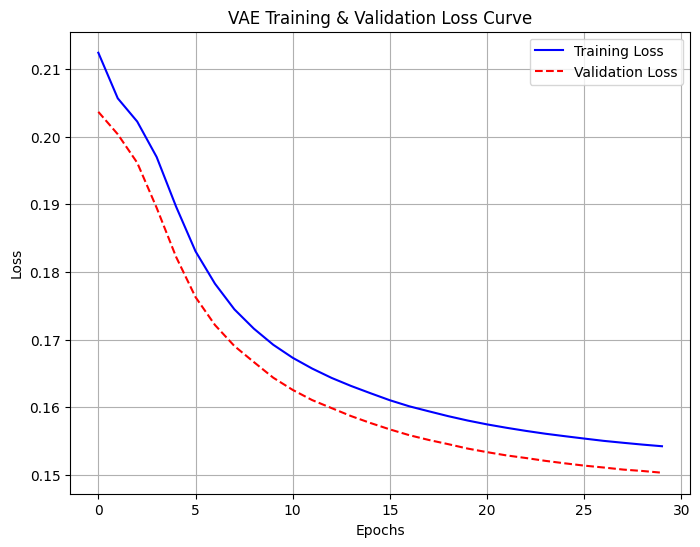

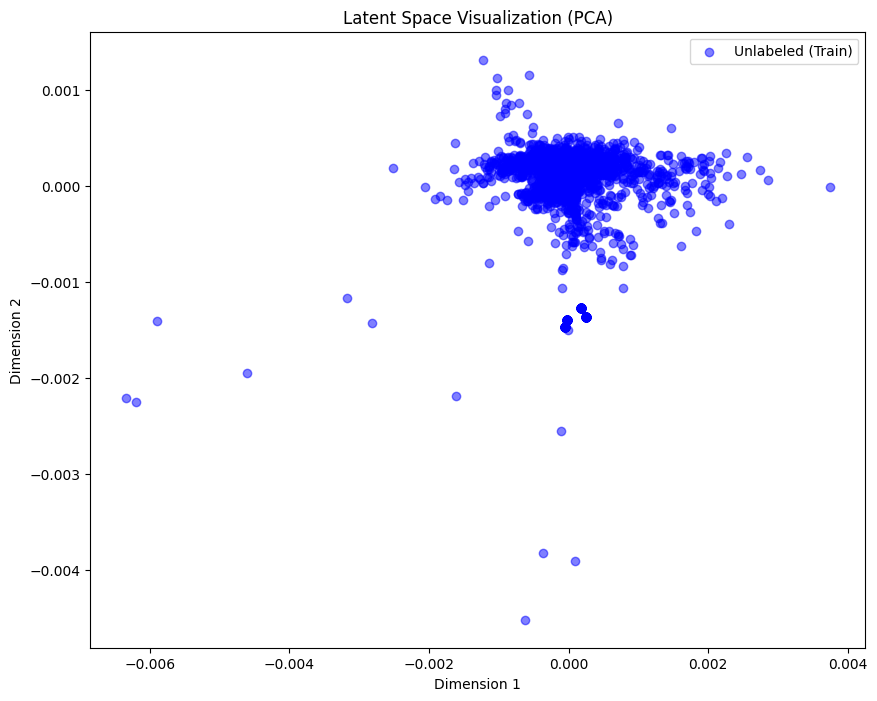

C:\Users\SCHUGD\AppData\Local\Temp\ipykernel_48916\3359197544.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


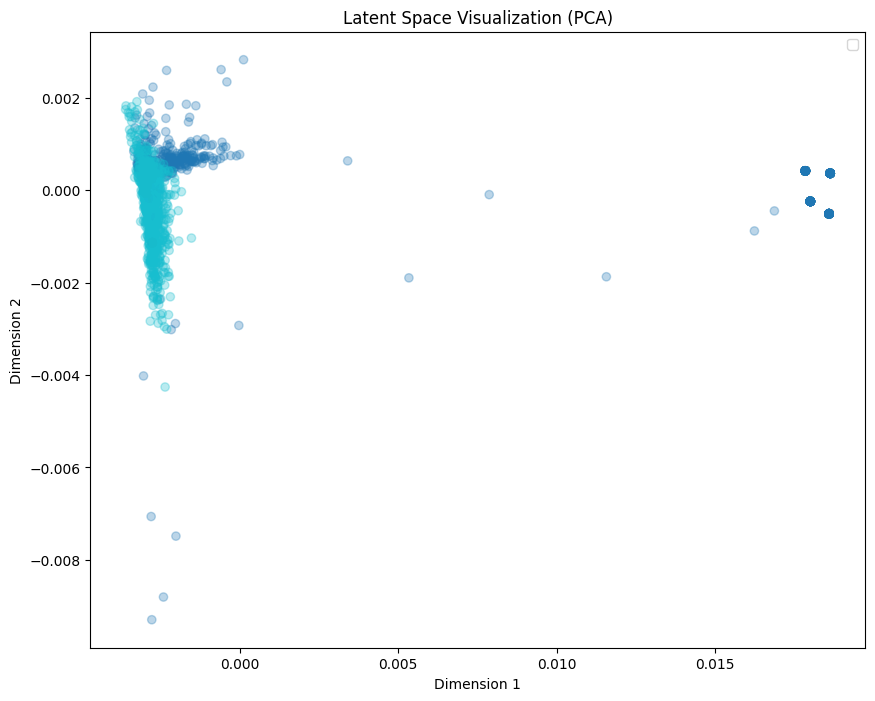

In [223]:
# Regular HYPERPARAMETERS 
input_dim = np.size(processeddataframe['features'][0])
epochs = 30
n_samples = 1  
learning_rate = 1e-4 
weight_decay = 1e-5
# FactorVAE
learning_rate_disc = 5e-5
# Annealing and Early stop
steps_anneal = epochs * len(train_dataset)  
validation_method = "VAE" # None, VAE, TC
patience = 5  

# IMPORTANT 
latent_dim= 45  
beta = 20
gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0
##################


vae = VAE_multiplesamples(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)

optimizer = tf.keras.optimizers.AdamW(learning_rate= learning_rate, weight_decay= weight_decay)
discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)

train_losses, val_losses, real_epochs, time, show_val = train_model(vae,optimizer,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, validation_method)


plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time, show_val= show_val)
get_latent_representations_label(vae, train_dataset,latent_dim, beta,n_critic,gamma,time, 'PCA', save = False)
get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,'PCA', save = True)
#get_latent_representations_label(vae, train_dataset, 'TSNE')

**HyperParamter Search**

Training with: latent_dim=20, beta=1, gamma=0, n_critic=0, validation_method=VAE
Latent Dimension = 20, Beta = 1, Gamma = 0, N_critic = 0, Rows in Training Data = 15000, Batch Size = 256
Epoch 1, Train Loss: 0.2352, Discriminator Loss: 0.0000 Disc Acc: 0.0000, Val Loss: 0.2330
💽Saved Model at Epoch 1💽
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "c:\Users\SCHUGD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\rnn.py", line 418, in <genexpr>
    output_ta_t = tuple(  File "c:\Users\SCHUGD\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\util\tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
Epoch 2, Train Loss: 0.2341, Discriminator Loss: 0.0000 Disc Acc: 0.0000, Val Loss: 0.2309
💽

Model: "vae_multiplesamples_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_21 (Sequential)      │ (None, 2500)           │       343,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (256, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (256, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_22 (Sequential)      │ (None, 50, 39)         │       323,639 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_23 (Sequential)      │ (None, 2)              │    11,292,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,059,081 (46.00 MB)

 Trainable params: 12,058,481 (46.00 MB)

 Non-trainable params: 600 (2.34 KB)

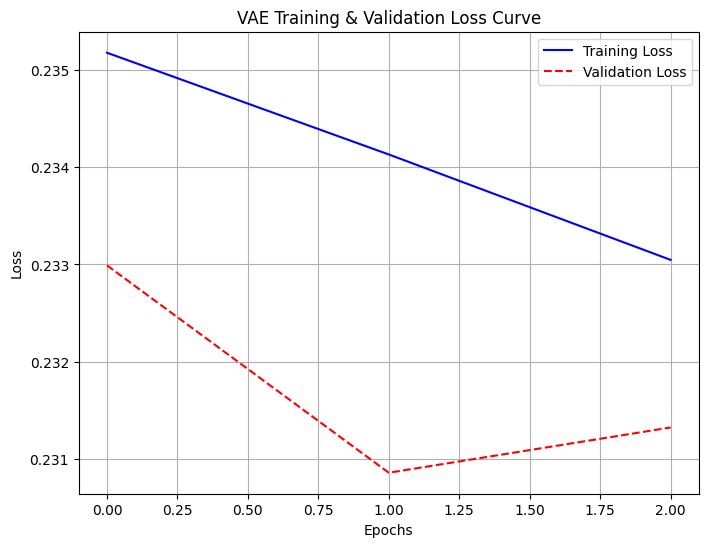

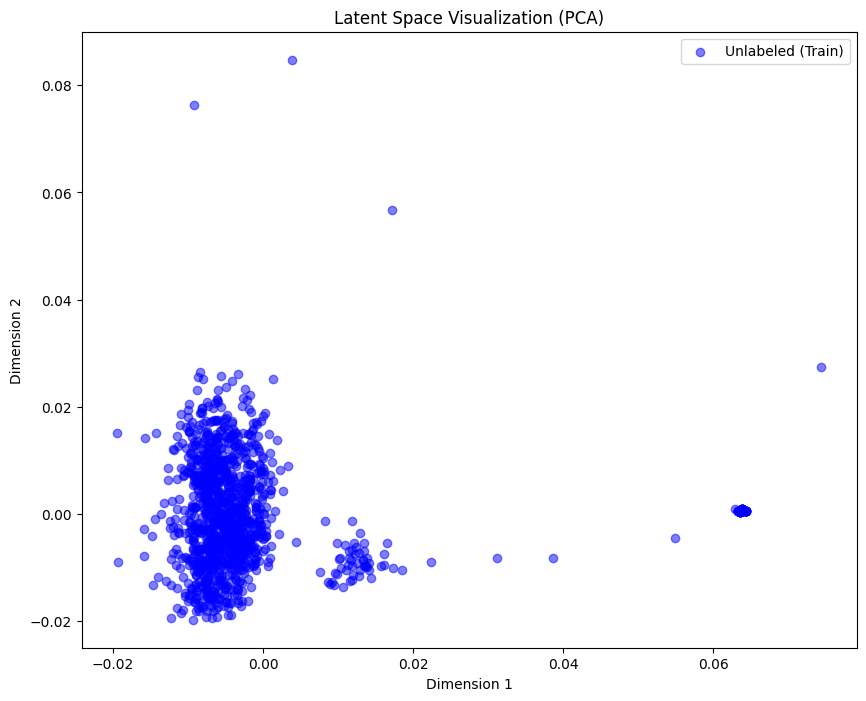

C:\Users\SCHUGD\AppData\Local\Temp\ipykernel_48916\3359197544.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


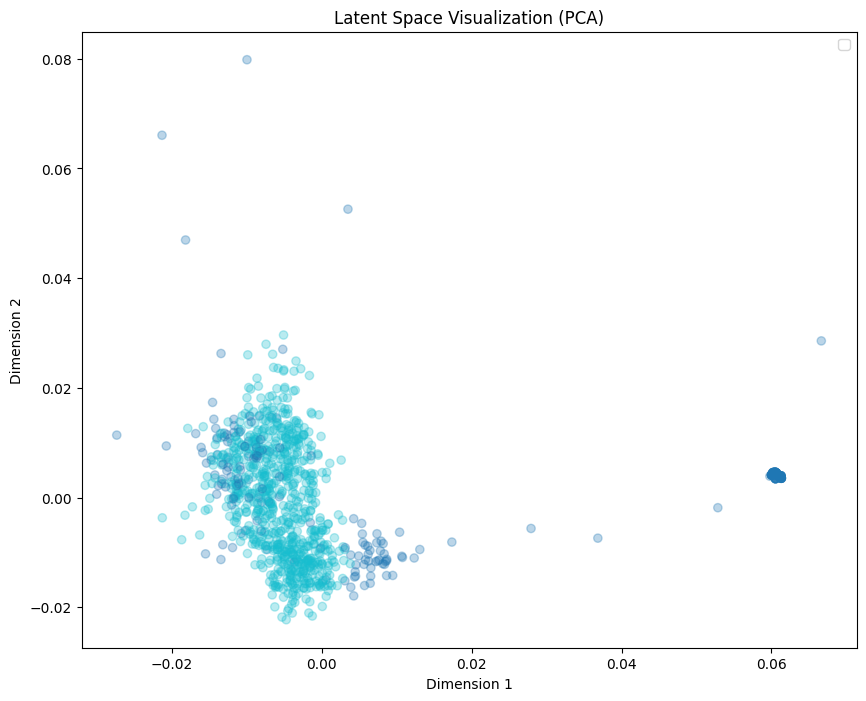

Training with: latent_dim=20, beta=1, gamma=0.5, n_critic=1, validation_method=None
Latent Dimension = 20, Beta = 1, Gamma = 0.5, N_critic = 1, Rows in Training Data = 15000, Batch Size = 256
Epoch 1, Train Loss: 0.2340, Discriminator Loss: 0.6928 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 1💽
Epoch 2, Train Loss: 0.2326, Discriminator Loss: 0.6934 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 2💽
Epoch 3, Train Loss: 0.2335, Discriminator Loss: 0.6926 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 3💽
Epoch 4, Train Loss: 0.2311, Discriminator Loss: 0.6937 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 4💽
Epoch 5, Train Loss: 0.2285, Discriminator Loss: 0.6940 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 5💽
Epoch 6, Train Loss: 0.2260, Discriminator Loss: 0.6930 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 6💽
Epoch 7, Train Loss: 0.2233, Discriminator Loss: 0.6932 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch

Model: "vae_multiplesamples_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_24 (Sequential)      │ (None, 2500)           │       343,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (128, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (128, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_25 (Sequential)      │ (None, 50, 39)         │       323,639 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_26 (Sequential)      │ (None, 2)              │    11,292,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,059,081 (46.00 MB)

 Trainable params: 12,058,481 (46.00 MB)

 Non-trainable params: 600 (2.34 KB)

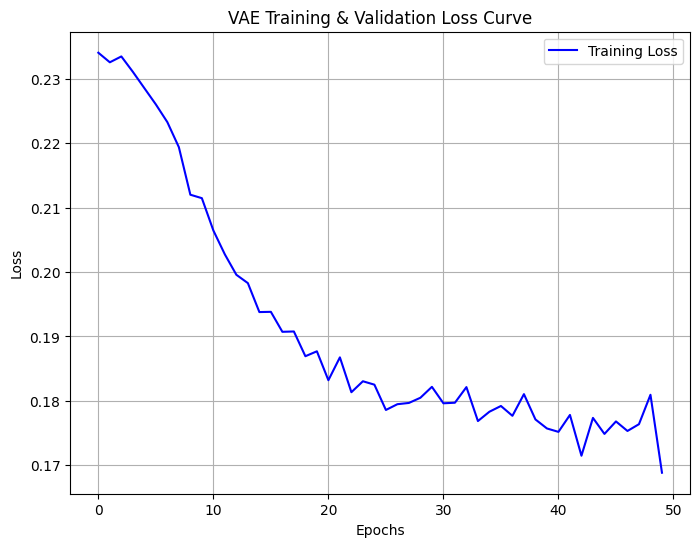

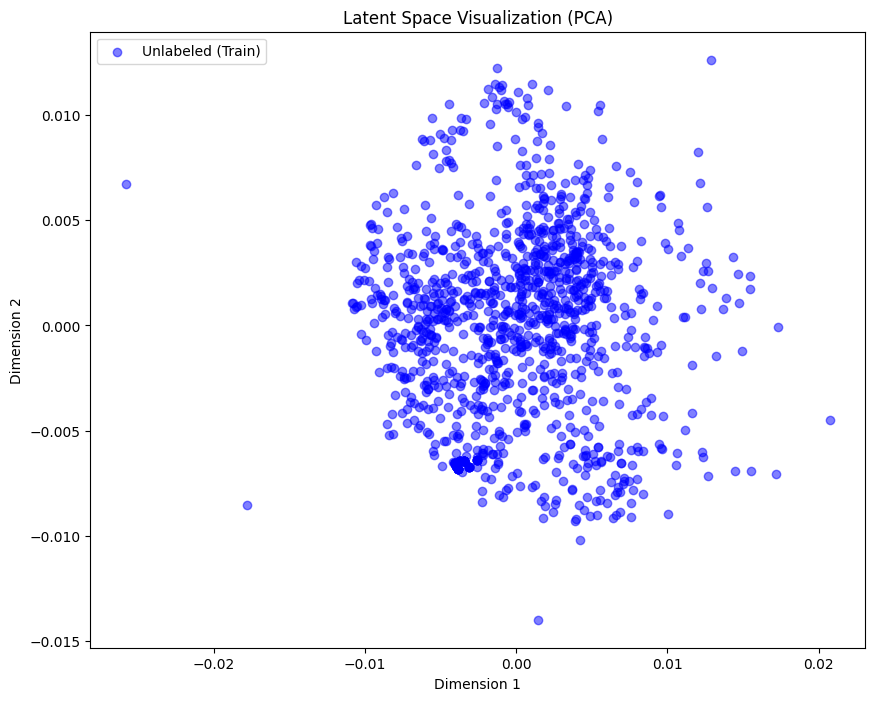

C:\Users\SCHUGD\AppData\Local\Temp\ipykernel_48916\3359197544.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


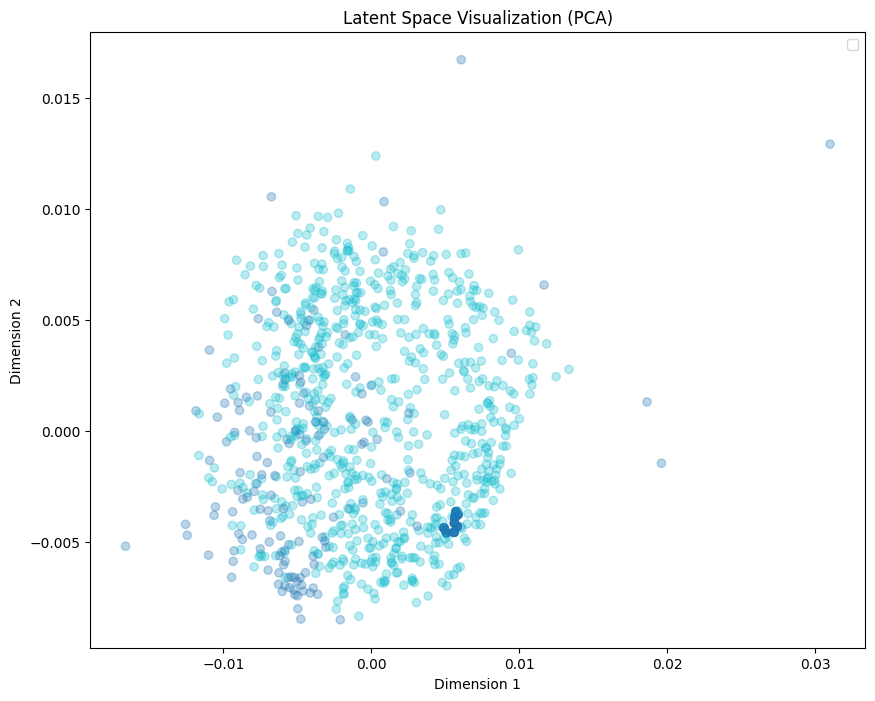

Training with: latent_dim=20, beta=1, gamma=0.5, n_critic=5, validation_method=None
Latent Dimension = 20, Beta = 1, Gamma = 0.5, N_critic = 5, Rows in Training Data = 15000, Batch Size = 256
Epoch 1, Train Loss: 0.2369, Discriminator Loss: 0.6934 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 1💽
Epoch 2, Train Loss: 0.2339, Discriminator Loss: 0.6936 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 2💽
Epoch 3, Train Loss: 0.2313, Discriminator Loss: 0.6933 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 3💽
Epoch 4, Train Loss: 0.2303, Discriminator Loss: 0.6926 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 4💽
Epoch 5, Train Loss: 0.2293, Discriminator Loss: 0.6942 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 5💽
Epoch 6, Train Loss: 0.2281, Discriminator Loss: 0.6935 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 6💽
Epoch 7, Train Loss: 0.2231, Discriminator Loss: 0.6940 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch

Model: "vae_multiplesamples_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_27 (Sequential)      │ (None, 2500)           │       343,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (128, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (128, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_28 (Sequential)      │ (None, 50, 39)         │       323,639 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_29 (Sequential)      │ (None, 2)              │    11,292,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,059,081 (46.00 MB)

 Trainable params: 12,058,481 (46.00 MB)

 Non-trainable params: 600 (2.34 KB)

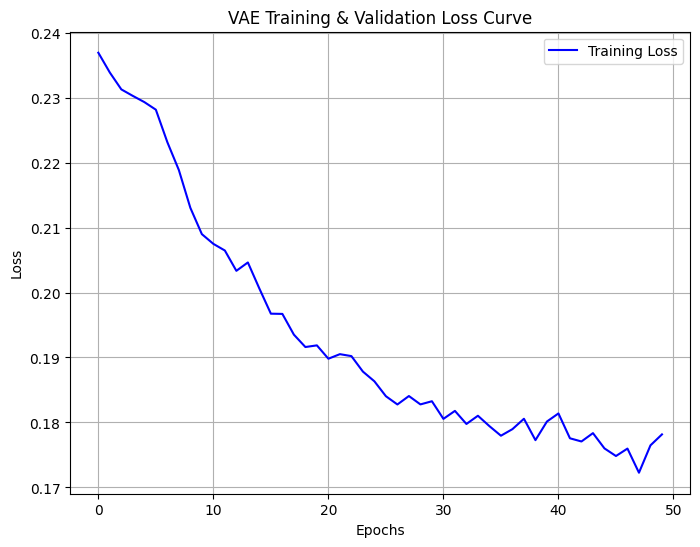

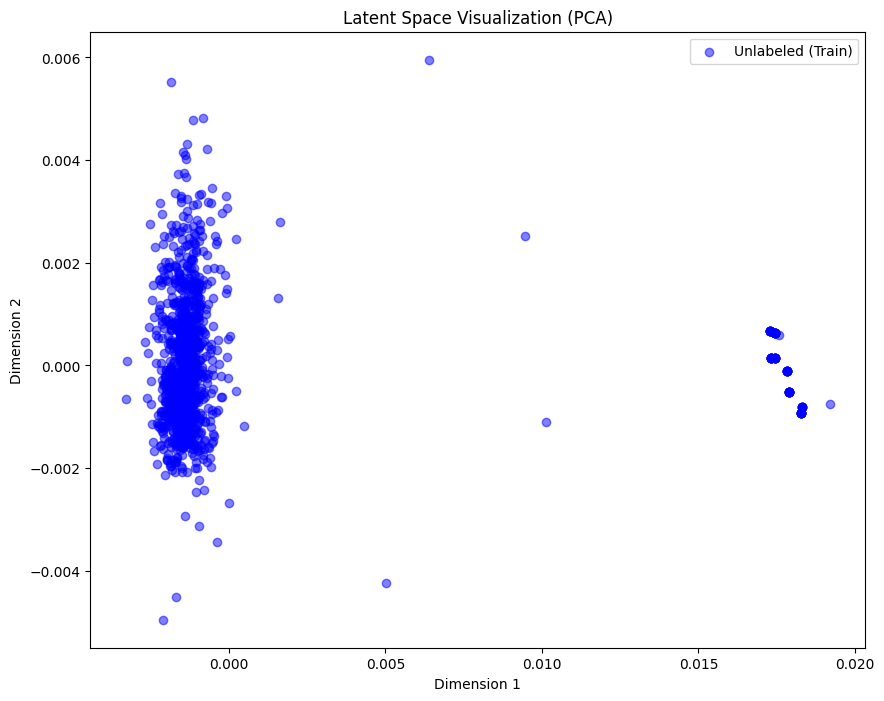

C:\Users\SCHUGD\AppData\Local\Temp\ipykernel_48916\3359197544.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


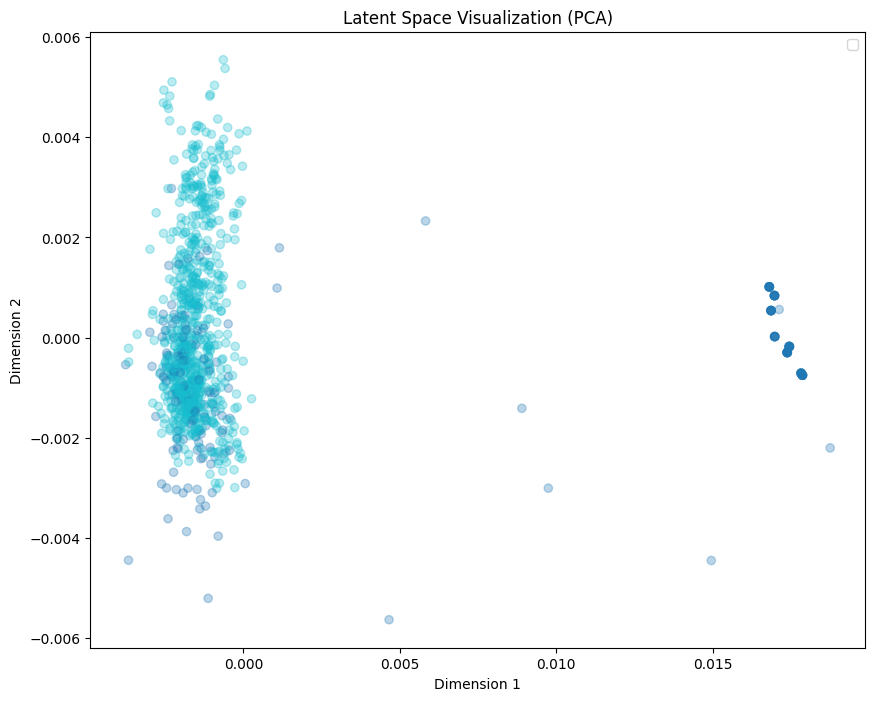

Training with: latent_dim=20, beta=1, gamma=0.5, n_critic=10, validation_method=None
Latent Dimension = 20, Beta = 1, Gamma = 0.5, N_critic = 10, Rows in Training Data = 15000, Batch Size = 256
Epoch 1, Train Loss: 0.2351, Discriminator Loss: 0.6936 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 1💽
Epoch 2, Train Loss: 0.2337, Discriminator Loss: 0.6934 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 2💽
Epoch 3, Train Loss: 0.2312, Discriminator Loss: 0.6939 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 3💽
Epoch 4, Train Loss: 0.2260, Discriminator Loss: 0.6937 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 4💽
Epoch 5, Train Loss: 0.2268, Discriminator Loss: 0.6937 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 5💽
Epoch 6, Train Loss: 0.2235, Discriminator Loss: 0.6933 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 6💽
Epoch 7, Train Loss: 0.2185, Discriminator Loss: 0.6935 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epo

Model: "vae_multiplesamples_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_30 (Sequential)      │ (None, 2500)           │       343,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (128, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (128, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (None, 50, 39)         │       323,639 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 2)              │    11,292,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,059,081 (46.00 MB)

 Trainable params: 12,058,481 (46.00 MB)

 Non-trainable params: 600 (2.34 KB)

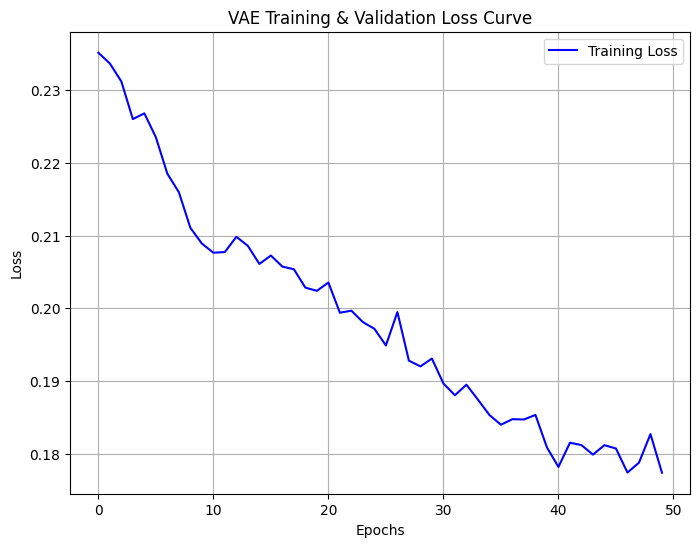

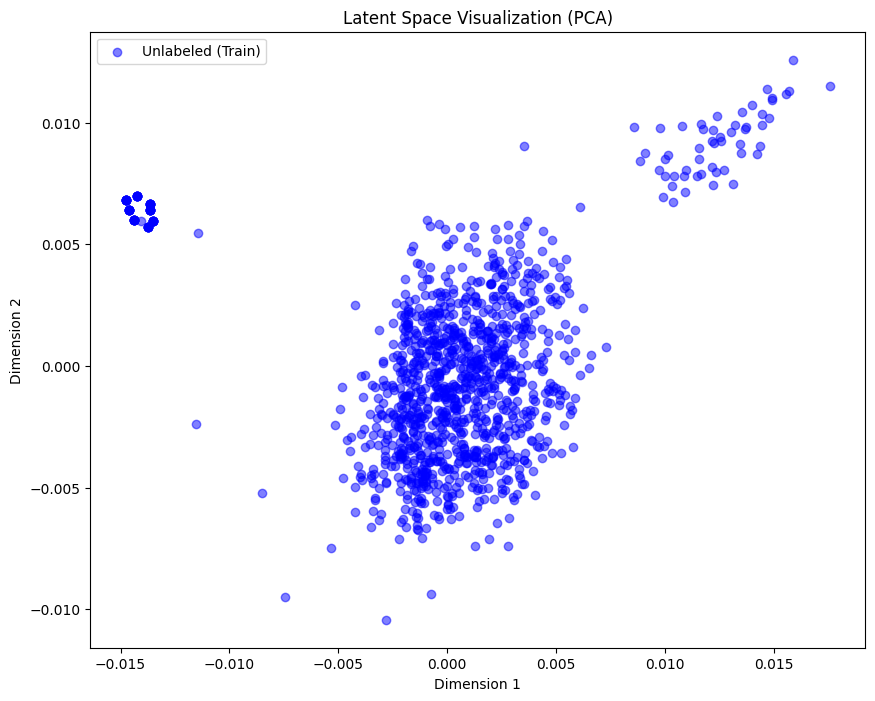

C:\Users\SCHUGD\AppData\Local\Temp\ipykernel_48916\3359197544.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


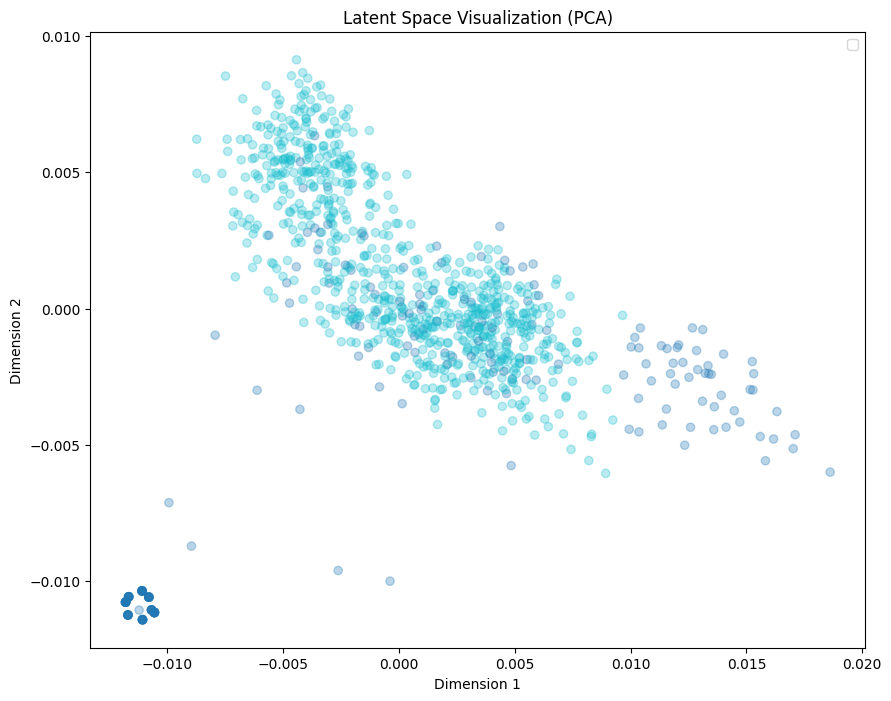

Training with: latent_dim=20, beta=1, gamma=5, n_critic=1, validation_method=None
Latent Dimension = 20, Beta = 1, Gamma = 5, N_critic = 1, Rows in Training Data = 15000, Batch Size = 256
Epoch 1, Train Loss: 0.2366, Discriminator Loss: 0.6935 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 1💽
Epoch 2, Train Loss: 0.2337, Discriminator Loss: 0.6936 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 2💽
Epoch 3, Train Loss: 0.2360, Discriminator Loss: 0.6931 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 3💽
Epoch 4, Train Loss: 0.2347, Discriminator Loss: 0.6934 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 4💽
Epoch 5, Train Loss: 0.2295, Discriminator Loss: 0.6932 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 5💽
Epoch 6, Train Loss: 0.2285, Discriminator Loss: 0.6938 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 6💽
Epoch 7, Train Loss: 0.2268, Discriminator Loss: 0.6937 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 7💽


Model: "vae_multiplesamples_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_33 (Sequential)      │ (None, 2500)           │       343,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (128, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (128, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_34 (Sequential)      │ (None, 50, 39)         │       323,639 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_35 (Sequential)      │ (None, 2)              │    11,292,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,059,081 (46.00 MB)

 Trainable params: 12,058,481 (46.00 MB)

 Non-trainable params: 600 (2.34 KB)

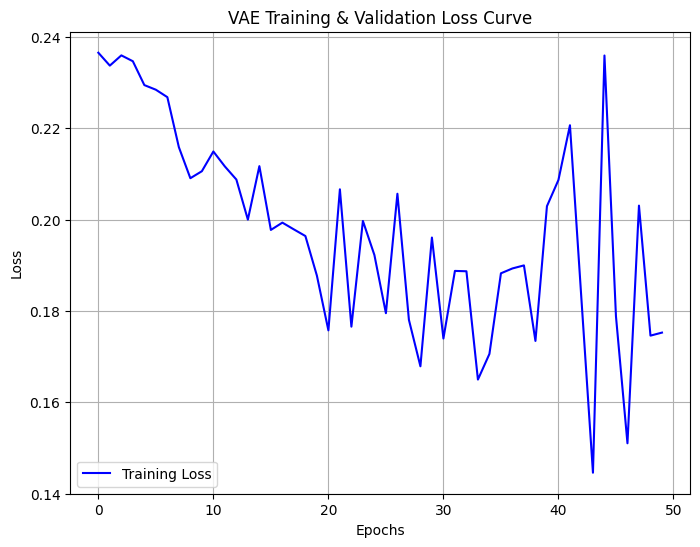

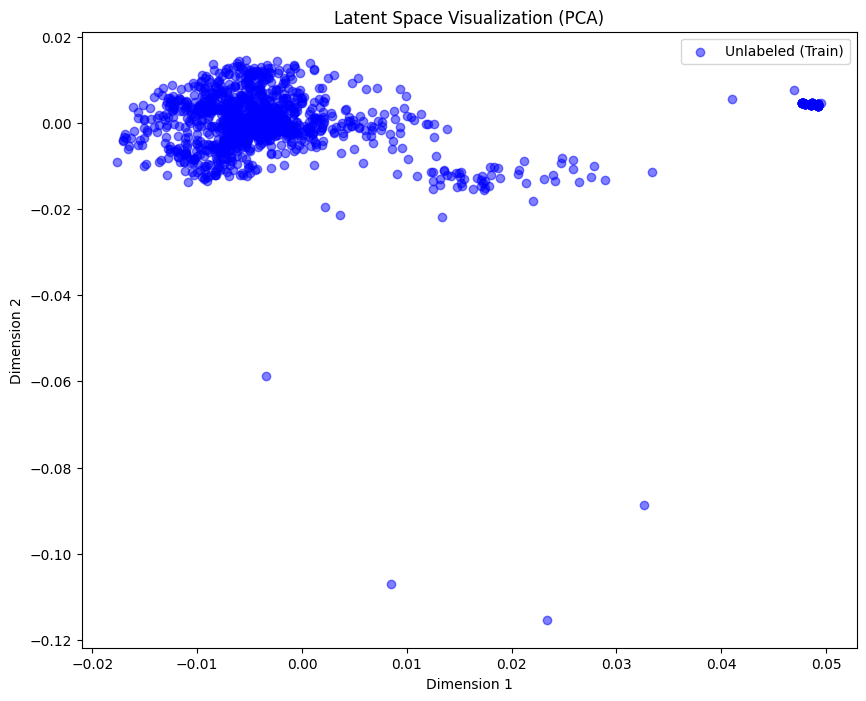

C:\Users\SCHUGD\AppData\Local\Temp\ipykernel_48916\3359197544.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


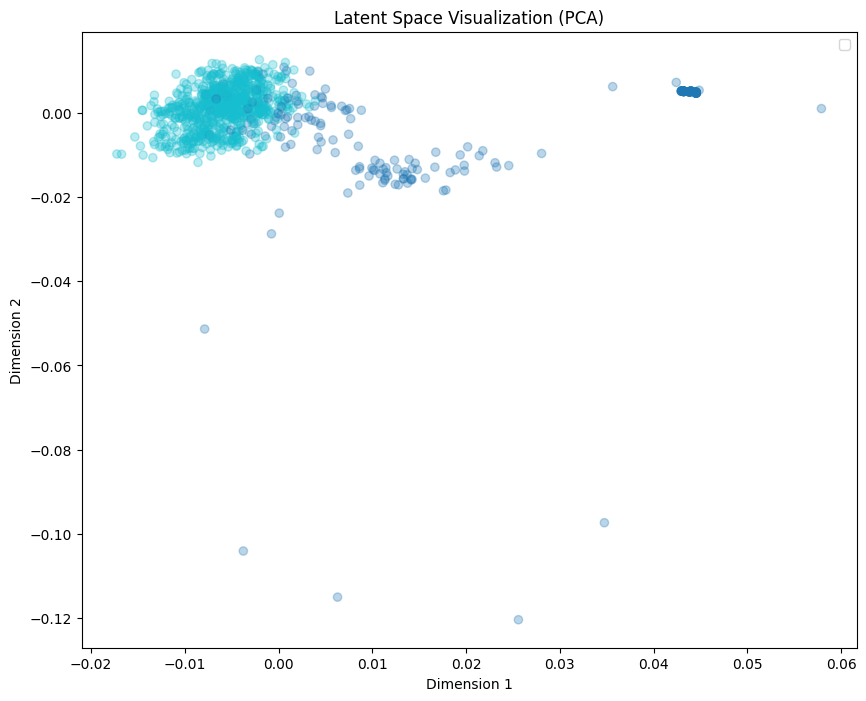

Training with: latent_dim=20, beta=1, gamma=5, n_critic=5, validation_method=None
Latent Dimension = 20, Beta = 1, Gamma = 5, N_critic = 5, Rows in Training Data = 15000, Batch Size = 256
Epoch 1, Train Loss: 0.2362, Discriminator Loss: 0.6935 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 1💽
Epoch 2, Train Loss: 0.2342, Discriminator Loss: 0.6933 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 2💽
Epoch 3, Train Loss: 0.2322, Discriminator Loss: 0.6937 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 3💽
Epoch 4, Train Loss: 0.2328, Discriminator Loss: 0.6937 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 4💽
Epoch 5, Train Loss: 0.2303, Discriminator Loss: 0.6931 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 5💽
Epoch 6, Train Loss: 0.2278, Discriminator Loss: 0.6935 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 6💽
Epoch 7, Train Loss: 0.2232, Discriminator Loss: 0.6938 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 7💽


Model: "vae_multiplesamples_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_36 (Sequential)      │ (None, 2500)           │       343,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (128, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (128, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_37 (Sequential)      │ (None, 50, 39)         │       323,639 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_38 (Sequential)      │ (None, 2)              │    11,292,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,059,081 (46.00 MB)

 Trainable params: 12,058,481 (46.00 MB)

 Non-trainable params: 600 (2.34 KB)

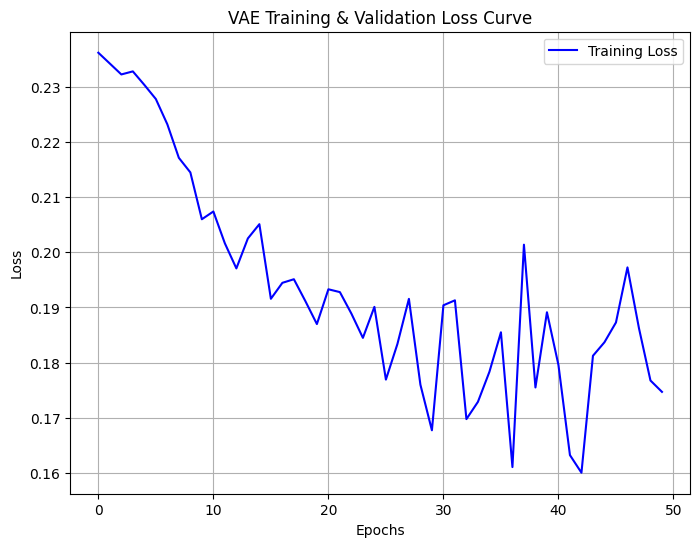

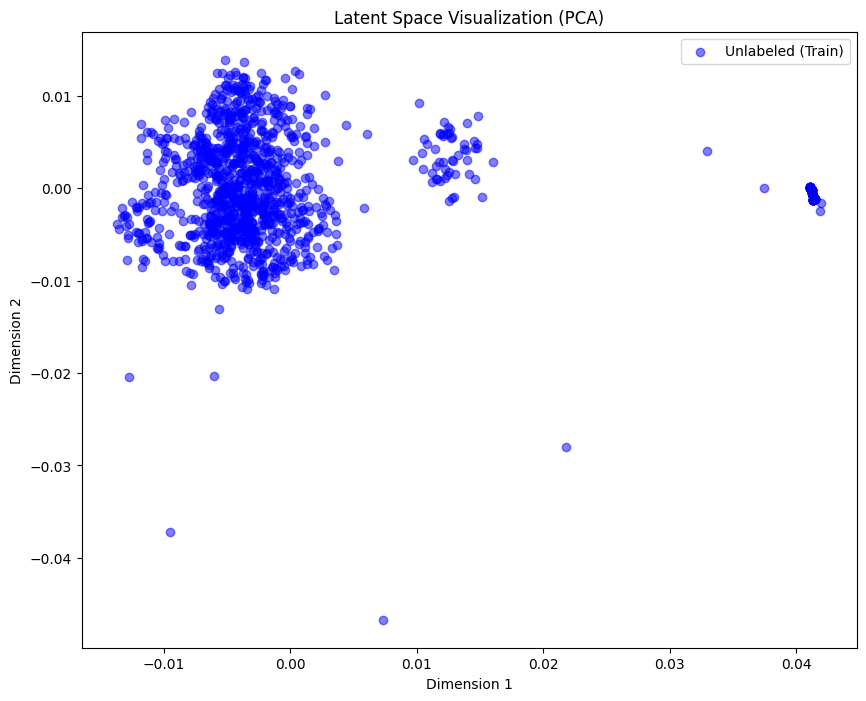

C:\Users\SCHUGD\AppData\Local\Temp\ipykernel_48916\3359197544.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


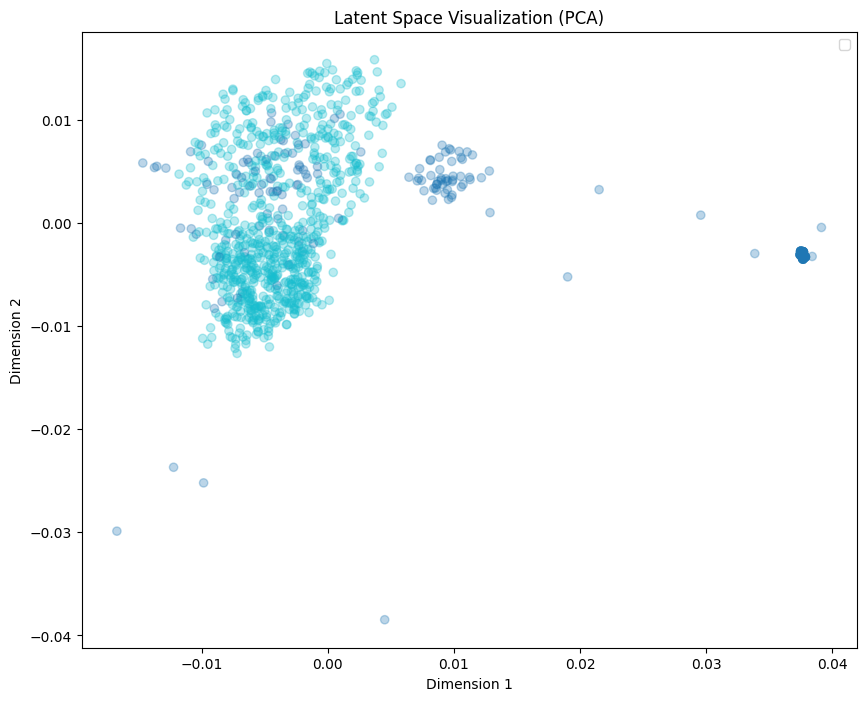

Training with: latent_dim=20, beta=1, gamma=5, n_critic=10, validation_method=None
Latent Dimension = 20, Beta = 1, Gamma = 5, N_critic = 10, Rows in Training Data = 15000, Batch Size = 256
Epoch 1, Train Loss: 0.2344, Discriminator Loss: 0.6931 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 1💽
Epoch 2, Train Loss: 0.2340, Discriminator Loss: 0.6941 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 2💽
Epoch 3, Train Loss: 0.2331, Discriminator Loss: 0.6935 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 3💽
Epoch 4, Train Loss: 0.2320, Discriminator Loss: 0.6934 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 4💽
Epoch 5, Train Loss: 0.2263, Discriminator Loss: 0.6939 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 5💽
Epoch 6, Train Loss: 0.2227, Discriminator Loss: 0.6937 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 6💽
Epoch 7, Train Loss: 0.2207, Discriminator Loss: 0.6935 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 7

Model: "vae_multiplesamples_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_39 (Sequential)      │ (None, 2500)           │       343,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (128, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (128, 20)              │        50,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_40 (Sequential)      │ (None, 50, 39)         │       323,639 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_41 (Sequential)      │ (None, 2)              │    11,292,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,059,081 (46.00 MB)

 Trainable params: 12,058,481 (46.00 MB)

 Non-trainable params: 600 (2.34 KB)

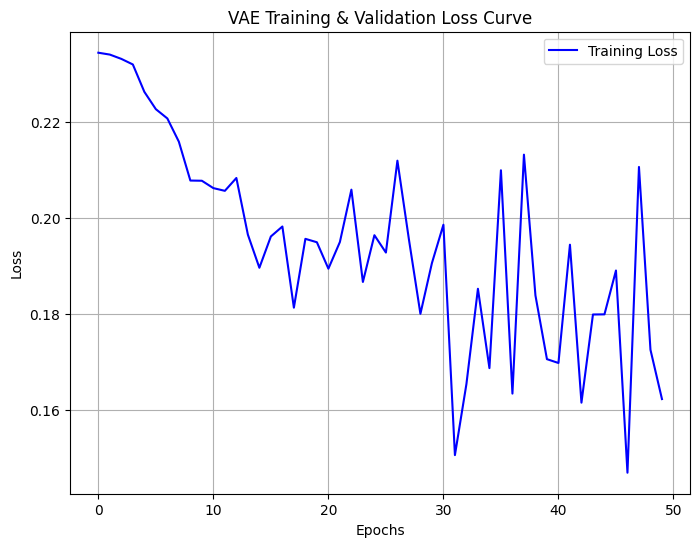

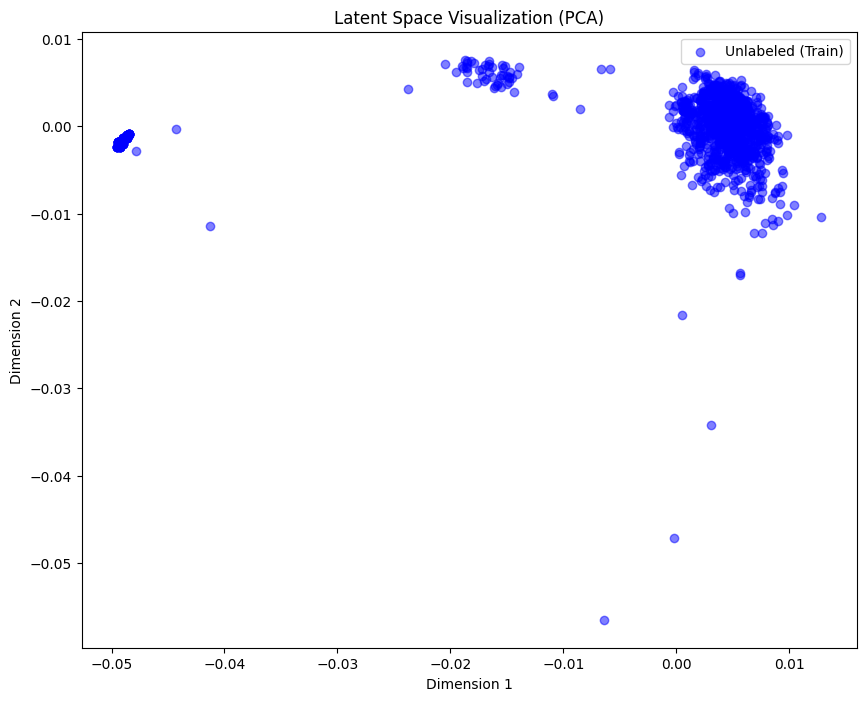

C:\Users\SCHUGD\AppData\Local\Temp\ipykernel_48916\3359197544.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


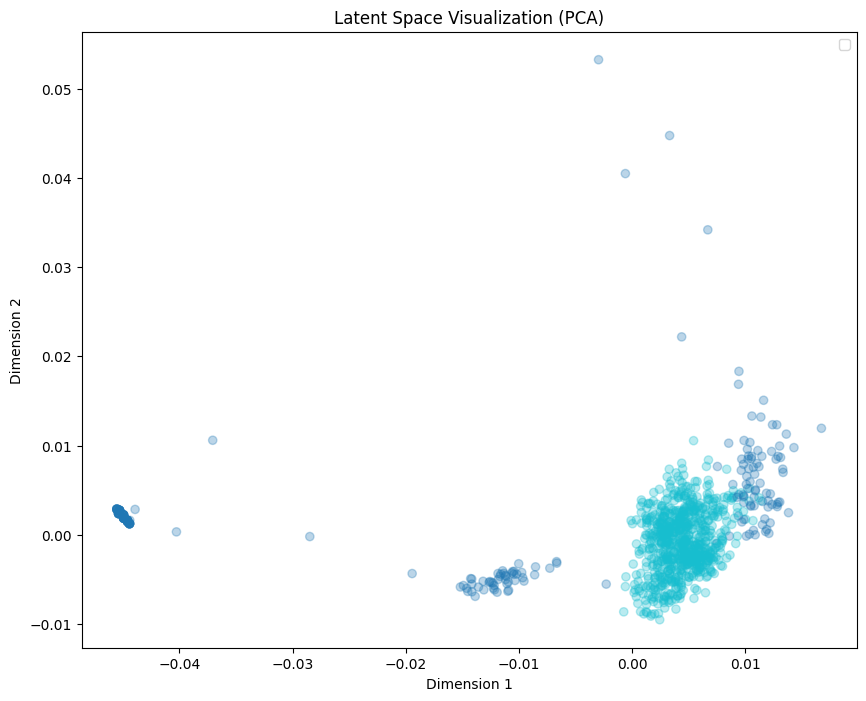

Training with: latent_dim=20, beta=1, gamma=10, n_critic=1, validation_method=None
Latent Dimension = 20, Beta = 1, Gamma = 10, N_critic = 1, Rows in Training Data = 15000, Batch Size = 256
Epoch 1, Train Loss: 0.2381, Discriminator Loss: 0.6936 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 1💽
Epoch 2, Train Loss: 0.2316, Discriminator Loss: 0.6934 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 2💽
Epoch 3, Train Loss: 0.2285, Discriminator Loss: 0.6932 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 3💽
Epoch 4, Train Loss: 0.2274, Discriminator Loss: 0.6931 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 4💽
Epoch 5, Train Loss: 0.2302, Discriminator Loss: 0.6949 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 5💽
Epoch 6, Train Loss: 0.2357, Discriminator Loss: 0.6945 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 6💽
Epoch 7, Train Loss: 0.2215, Discriminator Loss: 0.6932 Disc Acc: 0.0000, Val Loss: 0.0000
💽Saved Model at Epoch 7

KeyboardInterrupt: 

In [23]:
# Regular HYPERPARAMETERS 
input_dim = np.size(processeddataframe['features'][0])
epochs = 50
n_samples = 1  
learning_rate = 1e-4 
weight_decay = 1e-5
# FactorVAE
learning_rate_disc = 5e-5
# Annealing and Early stop
steps_anneal = epochs * len(train_dataset)  
validation_method = "VAE" # None, VAE, TC
patience = 5  
wait = 0  

# Hyperparameter search space
latent_dims = [20,28, 45, 64]  # Example values for latent dimension
beta_values = [1, 20, 30, 40]
gamma_values = [0,0.5, 5, 10]  # Ensure 0 is included
n_critic_values = [0,1, 5, 10]  # Ensure 0 is included


best_val_loss = float("inf")
best_params = None

# Iterate over all combinations
for latent_dim, beta, gamma, n_critic in itertools.product(latent_dims, beta_values, gamma_values, n_critic_values):
    # Ensure gamma and n_critic are both 0 or both >0
    if (gamma == 0 and n_critic != 0) or (gamma != 0 and n_critic == 0):
        continue  # Skip invalid combinations
    
    validation_method = "VAE" if gamma == 0 and n_critic == 0 else "None"
    
    print(f"Training with: latent_dim={latent_dim}, beta={beta}, gamma={gamma}, n_critic={n_critic}, validation_method={validation_method}")
    
    vae = VAE_multiplesamples(input_dim=input_dim, latent_dim=latent_dim, window_size=window_size)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)
    
    train_losses, val_losses, real_epochs, time, show_val = train_model(
        vae, optimizer, discriminator_optimizer, epochs, n_samples, input_dim, latent_dim, batch_size,
        beta, gamma, n_critic, steps_anneal, patience, validation_method
    )
    
    plot_loss_curve(train_losses, val_losses, real_epochs, latent_dim, time, show_val=show_val)
    get_latent_representations_label(vae, train_dataset, latent_dim, beta, n_critic, gamma, time, 'PCA', save=False)
    get_latent_representations_label(vae, test_dataset, latent_dim, beta, n_critic, gamma, time, 'PCA', save=True)


In [426]:
def bhattacharyya_distance(mu_normals, logvar_normals, mu_anomaly, logvar_anomaly):
    # Function compares how much distributions overlap
    
    sigma2_normals = np.exp(logvar_normals)  # normal variance
    sigma2_anomaly = np.exp(logvar_anomaly)  # anomaly variance

    diff_sq = (mu_normals - mu_anomaly) ** 2
    term1 = 0.25 * np.sum(diff_sq / (sigma2_normals + sigma2_anomaly), axis=1)

    term2 = 0.5 * np.sum(np.log(((sigma2_normals + sigma2_anomaly) / 2) / np.sqrt(sigma2_normals * sigma2_anomaly)), axis=1)

    distances = term1 + term2
    return np.min(distances)  

**GET Threshold for Train DATA**

In [427]:
load_vae = keras.models.load_model(model_path)
load_vae.trainable = False  # Freeze model weights
latent_only = True

# Compute reconstruction losses on the test set with multiple samples
n_samples = 10  # Number of latent samples during inference
results = []
reconstruction_losses = []

mean_train = []
variance_train = []

distances_threshold = []
normal_distances_threshold = []

for batch in train_dataset:
    reconstructed, mu, logvar = load_vae(batch, n_samples=n_samples, latent_only = latent_only)  
    batch_data = batch.numpy()  
    for i in range(len(batch)):
        mean_train.append(mu[i])
        variance_train.append(logvar[i])

            
for batch in val_dataset:
    reconstructed, mu, logvar = load_vae(batch, n_samples=n_samples, latent_only = latent_only)  

    if not latent_only:
        # Compute VAE loss
        reconstruction_errors = tf.reduce_mean(
            tf.square(tf.expand_dims(batch, axis=0) - reconstructed), axis = -1
        )  # Shape: (n_samples, batch_size, window_size)  

        # mean over samples and window_size
        mean_reconstruction_error = tf.reduce_mean(reconstruction_errors, axis=(2, 0))
        #max_reconstruction_error = tf.reduce_max(reconstruction_errors, axis=(2, 0))

    batch_data = batch.numpy()  
    for i in range(len(batch)):
        if not latent_only: 
            results.append(mean_reconstruction_error[i])

        distance = bhattacharyya_distance(mean_train, variance_train, mu[i], logvar[i])
        normal_distances_threshold.append(distance)
            

# Set anomaly threshold 
#normal_threshold = np.percentile(normal_distances_threshold, 99.5)
#normal_threshold = np.max(normal_distances_threshold) + np.percentile(normal_distances_threshold, (1 - 0.5)) #<-- maybe better
normal_threshold = np.max(normal_distances_threshold) * 10
print(f"Normal threshold: {normal_threshold:.7f}")

Normal threshold: 0.0467569


**TESTING**

In [428]:
load_vae = keras.models.load_model(model_path)
load_vae.trainable = False  # Freeze model weights
latent_only = True

n_samples = 10  # Number of latent samples during inference
results = []
reconstruction_losses = []

distances = []

mean_test = []
variance_test = []

for batch, label in test_dataset:
    reconstructed, mu, logvar = load_vae(batch, n_samples=n_samples, latent_only = latent_only)  # Use multiple samples
    
    # Compute reconstruction errors (mean over all features)
    if not latent_only:
        errors = tf.reduce_mean(tf.square(tf.expand_dims(batch, axis=0) - reconstructed), axis=-1)  # Shape: (n_samples, batch_size)

        # Compute mean reconstruction error across samples (axis=0) and features (axis=-1)
        mean_reconstruction_error = tf.reduce_mean(errors, axis=(0, 2))  # Shape: (batch_size,)
        #mean_reconstruction_error = tf.reduce_max(errors, axis=(0, 2))  # Shape: (batch_size,)
        reconstruction_losses.extend(mean_reconstruction_error)

    batch_data = batch.numpy()  # Convert Tensor to NumPy
    for i in range(len(batch_data)):
        if not latent_only:
            results.append(np.append(label[i], reconstruction_losses[i]))  # Store the label and max error per sample
        
        distance = bhattacharyya_distance(mean_train, variance_train, mu[i], logvar[i])
        distances.append(np.append(label[i], distance))

**ANOMALY DETECTION: Reconstruction**

In [ ]:
def reconstruction_probability(mu, logvar, reconstructed, input):
    # Compute the log probability of the input under the reconstructed distribution
    std = tf.exp(0.5 * logvar)
    log_prob = -0.5 * (tf.math.log(2 * np.pi) + logvar + tf.square(input - mu) / tf.square(std))
    return tf.reduce_sum(log_prob, axis=-1)

In [ ]:
# Append anomaly label (1 = anomaly, 0 = normal) directly to `results`
for i in range(len(results)):
    reconstruction_error = results[i][-1] 
    anomaly_label = 1 if reconstruction_error > threshold else 0  
    results[i] = np.append(results[i], anomaly_label)  

# Print summary
print(f"Anomaly threshold: {threshold:.4f}")
print(f"Number of anomalies detected: {sum(r[-1] for r in results)}")

# Convert results to DataFrame
columns = []
columns.append("True_Label")
columns.append("Reconstruction_Error")  # Add a new column for error
columns.append("Anomaly")  # Add anomaly label column
results_df = pd.DataFrame(results, columns=columns)

predicted = results_df['Anomaly'].astype(int)
true_labels = results_df['True_Label'].astype(int)

excel_file_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/model_results2.xlsx'

save_results_to_excel(model_name, true_labels, predicted, excel_file_path)
get_confusion_matrix(true_labels, predicted, latent_dim, epochs, time)


**ANOMALY DETECTION: Latent Space**

Anomaly threshold: 0.0467569
Number of anomalies detected: 373.0
Confusion Matrix:
[[1222    0]
 [   1  373]]

Performance Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1222
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1596
   macro avg       1.00      1.00      1.00      1596
weighted avg       1.00      1.00      1.00      1596



c:\Users\SCHUGD\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


✅ Results saved to sheet 'LSTM_VAE_LD36_EP20_NT7000_16-10' in /Users/SCHUGD/Desktop/MasterThesis/Code/model_results2.xlsx


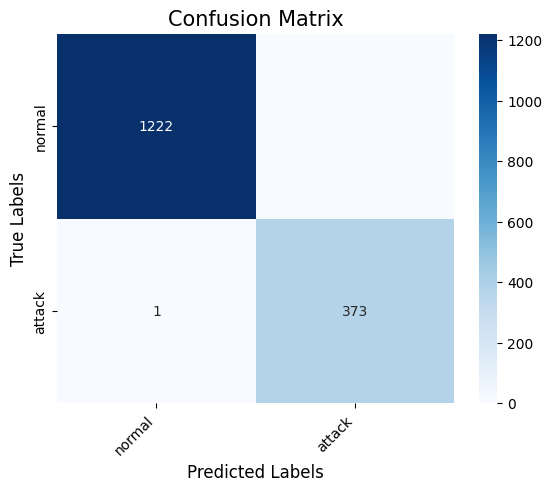

In [429]:
# Look if distances is over normal threshold
for i in range(len(distances)):
    latent_distance = distances[i][-1] 
    anomaly_label = 1 if latent_distance > normal_threshold else 0  
    distances[i] = np.append(distances[i], anomaly_label)  

# Print summary
print(f"Anomaly threshold: {normal_threshold:.7f}")
print(f"Number of anomalies detected: {sum(r[-1] for r in distances)}")

# Convert results to DataFrame
columns = []
columns.append("True_Label")
columns.append("Distance")  # Add a new column for error
columns.append("Anomaly")  # Add anomaly label column
distances_df = pd.DataFrame(distances, columns=columns)

predicted = distances_df['Anomaly'].astype(int)
true_labels = distances_df['True_Label'].astype(int)

excel_file_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/model_results2.xlsx'

save_results_to_excel(model_name, true_labels, predicted, excel_file_path)
get_confusion_matrix(true_labels, predicted, latent_dim, epochs, time)
